<div style="display: flex; background-color: RGB(87, 100, 144);">
<h1 style="margin: auto; padding: 30px 30px 10px 30px;">P2 - Analyze data from Education Systems</h1>
</div>
<div style="display: flex; background-color: RGB(87, 100, 144);">
<h2 style="margin: auto; padding: 10px 30px 30px 30px;">Data Scientist course</h2>
</div>

<a class="anchor" id="table_of_contents"></a>
# Table of Contents

* [Chapter 1. Libraries and functions](#chapter1)
    * [1.1. Importing libraries](#section_1_1)
    * [1.2. Functions declaration](#Section_1_2)
* [Chapter 2. Importing files](#chapter2)
    * [2.1. Importing and preparing files](#section_2_1)
* [Chapter 3. Initial Data Analysis](#chapter3)
    * [3.1. Initial Data Analysis Summary based on load](#section_3_1)
    * [3.2. Selecting the datasets and columns to work on](#section_3_2)
    * [3.3. Making the initial cleaning](#section_3_3)
    * [3.4. Making the selection of indicators](#section_3_4)
    * [3.5. Selecting the countries based on Indicators](#section_3_5)
* [Chapter 4. Analyzing the selected countries](#chapter4)
    * [4.1. Country comparison by indicator](#section_4_1)
    * [4.2. Potential customers by country](#section_4_2)
    * [4.3. Evolution of internet in the first 20 countries of potential clients](#section_4_3)
    * [4.4. Evolution of potential customers in the first 20 countries of potential clients](#section_4_4)
    * [4.5. Internet penetration compared to population ages 15-24](#section_4_5)
    * [4.6. Normalization of the selected indicator for each country](#section_4_6)
    * [4.7. Normalization of the selected indicator by region](#section_4_7) 
* [Chapter 5. Countries by score](#chapter5)
    * [5.1. Selecting countries by score](#section_5_1)

## Chapter 1.

<a class="anchor" id="chapter1"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Libraries and functions</h2>
</div>

#### 1.1.

<a class="anchor" id="section_1_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">1.1. Importing libraries</h3>
</div>

In [1]:
import io
from math import prod
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

#### 1.2.

<a class="anchor" id="Section_1_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_initial_analysis(df, columns, name_df):
    """
    Initial analysis on the DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame to analyze.
        columns (list): Dataframe keys in list format.
        name_df (str): DataFrame name.

    Returns:
        None. 
        Print the initial analysis on the DataFrame. 
    """
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
  
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["Name", "Type"])
        df_resume["Records"] = list(df.count())
        
        print("\nInitial Analysis of", name_df, "dataset")
        print("--------------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                    print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        print("\n- Type object and records by columns         (",memory_usage,")")
        print("--------------------------------------------------------------------------")
        print(df_resume.sort_values("Records", ascending=False))
        

def comparison_dfs(df_original, df_copy):
    """
    Create a DataFrame based on comparación between the original DataFrame and the copy DataFrame.
    Args:
        df_original (pandas.DataFrame): DataFrame original.
        df_copy (pandas.DataFrame): DataFrame copy.
    Returns:
        df_comparison (pandas.DataFrame): DataFrame comparison.
    """
    df_comparison = pd.DataFrame({
        "Moment" : ["Before", "After"],
        "Total values" : [prod(df_original.shape), prod(df_copy.shape)], 
        "Valid values" : [(prod(df_original.shape)-df_original.isna().sum().sum()), (prod(df_copy.shape)-df_copy.isna().sum().sum())],
        "Missing values" : [df_original.isna().sum().sum(), df_copy.isna().sum().sum()]
    })
    return df_comparison



def aggregate_evolution_of_potential_customers(row):
    """
    Calculate the potential customer based on a row
    
    The normalization method used in this function is The min-max approach 
    (often called normalization) rescales the feature to a hard and fast 
    range of [0,1] by subtracting the minimum value of the feature then dividing by the range.
    
    Args:
        row (pandas.DataFrame.row): DataFrame row.
    Returns:
        Calculation of potential customer
    """ 
    return (row["Enrolment in upper secondary education"] + row["Enrolment in tertiary education"]) * row["Internet users"]/100


def df_normalization(df, identifier_column):
    """
    Dataframe normalization.
    
    The normalization method used in this function is The min-max approach 
    (often called normalization) rescales the feature to a hard and fast 
    range of [0,1] by subtracting the minimum value of the feature then dividing by the range.
    
    Args:
        df (pandas.DataFrame): DataFrame to normalize.
        identifier_column: Dataframe key
    Returns:
        df (pandas.DataFrame): DataFrame normalized.
    """   
    
    df_new  = pd.DataFrame()
    
    for col in df.columns:
        if col == identifier_column:
            df_new[col]= df[col]
        else:
            df_new[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    return df_new

## Chapter 2.

<a class="anchor" id="chapter2"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Importing files</h2>
</div>

#### 2.1.

<a class="anchor" id="section_2_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">2.1. Importing and preparing files</h3>
</div>

In [3]:
# Importing EdStatsCountry dataset
df_country = pd.read_csv("datasets/EdStatsCountry.csv")
df_country.head(3)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN


In [4]:
# initial analysis of dataset
df_initial_analysis(df_country, ["Country Code"], "country")


Initial Analysis of country dataset
--------------------------------------------------------------------------
- Dataset shape:                  241 rows and 32 columns
- Total of NaN values:            2354
- Percentage of NaN:              30.52 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 31']

- The key(s): ['Country Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 60.4+ KB )
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      241
3                                           Long Name   object      241
1                                          Short Name   object      241
2                                       

<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsCountry"</h3>
    - This dataset has general economic and geographic information about countries.<br/>
    - The primary key is unique.<br/>
    - There is no null row.<br/>
    - For this dataset, there are no problems.<br/>
    - There is only one null column, but it is a ghost column. 
    - The percentage of null is reasonable, but we should wait to review all dataset to consider that.
</div>

In [5]:
# Importing EdStatsSeries dataset
df_serie = pd.read_csv("datasets/EdStatsSeries.csv")
df_serie.head(3)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15-19 with...,Percentage of female population age 15-19 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 ...,Percentage of population age 15-19 with no edu...,Percentage of population age 15-19 with no edu...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15+ with n...,Percentage of female population age 15+ with n...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# initial analysis of dataset
df_initial_analysis(df_serie, ["Series Code"], "series")


Initial Analysis of series dataset
--------------------------------------------------------------------------
- Dataset shape:                  3665 rows and 21 columns
- Total of NaN values:            55203
- Percentage of NaN:              71.72 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         6
  + The empty column are:          ['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']

- The key(s): ['Series Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 601.4+ KB )
--------------------------------------------------------------------------
                                   Name     Type  Records
0                           Series Code   object     3665
13                               Source   object     3665
2                        Indicator Name   obje

<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsSeries"</h3>
    - This dataset has general information about indicators.<br/>
    - The primary key is unique.<br/>
    - There is no null row.<br/>
    - For this dataset, there are problems.<br/>
    - Most of the data is null in the dataset.<br/>
    - There are 6 null columns.<br/>
    - Most of the data is null in the dataset, but we should wait to review all dataset to consider that.<br/>
    - We could consider Topic column to group indicators by it. 
</div>

In [7]:
# Importing EdStatsCountry-Series dataset
df_country_series = pd.read_csv("datasets/EdStatsCountry-Series.csv")
df_country_series.head(3)

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN


In [8]:
# initial analysis of dataset
df_initial_analysis(df_country_series, ["CountryCode", "SeriesCode"], "country-series")


Initial Analysis of country-series dataset
--------------------------------------------------------------------------
- Dataset shape:                  613 rows and 4 columns
- Total of NaN values:            613
- Percentage of NaN:              25.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 3']

- The key(s): ['CountryCode', 'SeriesCode'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 19.3+ KB )
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object      613
1   SeriesCode   object      613
2  DESCRIPTION   object      613
3   Unnamed: 3  float64        0


<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsCountry-Series"</h3>
    - This dataset has information related between "Country" dataset and "Serie" datasets.<br/>
    - For this dataset, there are no problems.<br/>
    - Initially, we can rule out this dataset, but we should wait to review all dataset to consider that.
</div>

In [9]:
# Importing EdStatsFootNote dataset
df_foot_note = pd.read_csv("datasets/EdStatsFootNote.csv")
df_foot_note.head(3)

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN


In [10]:
# initial analysis of dataset
df_initial_analysis(df_foot_note, ["CountryCode", "SeriesCode"], "foot-note")


Initial Analysis of foot-note dataset
--------------------------------------------------------------------------
- Dataset shape:                  643638 rows and 5 columns
- Total of NaN values:            643638
- Percentage of NaN:              20.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 4']

- The key(s): ['CountryCode', 'SeriesCode'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns         ( memory usage: 24.6+ MB )
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object   643638
1   SeriesCode   object   643638
2         Year   object   643638
3  DESCRIPTION   object   643638
4   Unnamed: 4  float64        0


<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsFootNote"</h3>
    - Similar to EdStatsFootNote dataset, this dataset has information related between "Country" dataset and "Serie" datasets.<br/>
    - For this dataset, there are no problems.<br/>
    - Initially, we can rule out this dataset, but we should wait to review all dataset to consider that.
</div>

In [11]:
# Importing EdStatsData dataset
df_data = pd.read_csv("datasets/EdStatsData.csv")
df_data.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.365540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arab World,ARB,"Adjusted net enrolment rate, primary, female (%)",SE.PRM.TENR.FE,43.351101,43.318150,44.640701,45.845718,46.449501,48.363892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Arab World,ARB,"Adjusted net enrolment rate, primary, gender p...",UIS.NERA.1.GPI,0.658570,0.656400,0.663290,0.672040,0.672610,0.691760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arab World,ARB,"Adjusted net enrolment rate, primary, male (%)",SE.PRM.TENR.MA,65.826233,65.993584,67.301857,68.219078,69.059013,69.914551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Arab World,ARB,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Arab World,ARB,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# initial analysis of dataset
df_initial_analysis(df_data, ["Country Code", "Indicator Code"], "data")


Initial Analysis of data dataset
--------------------------------------------------------------------------
- Dataset shape:                  886930 rows and 70 columns
- Total of NaN values:            53455179
- Percentage of NaN:              86.1 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 69']

- The key(s): ['Country Code', 'Indicator Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 473.7+ MB )
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   886930
2   Indicator Name   object   886930
3   Indicator Code   object   886930
1     Country Code   object   886930
44            2010  float64   242442
..             ...      ...      ...
7             1973  float64    35545
5         

<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsData"</h3>
    - It seems the main dataset. It has the information by country, indicator and multiple years.<br/>
    - There is only on column null, but it is a ghost column.<br/>
    - The primary key combination is unique.<br/>
    - For this dataset, there are some problems.<br/> 
    - In the firts rows, we can see a conutry name called Arab World, so... it is necesary verify all countries in dataset.<br/>
    - Most of the data is null in the dataset, but we should wait to select the countries/indicators to analyze to verify that point.<br/>
    - Despite the amount of null data in dataset, it has a lot of data. 
</div>

## Chapter 3.

<a class="anchor" id="chapter3"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Initial Data Analysis</h2>
</div>

#### 3.1.

<a class="anchor" id="section_3_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.1. Initial Data Analysis Summary based on load</h3>
</div>

- Knowing the entities of the datasets.<br>
    - **`Country`** dataset **`"EdStatsCountry.csv"`**.<br>
    General economic and geographic information about countries in the world.
    
    - **`Serie`** dataset **`"EdStatsSeries.csv"`**.<br>
    General information about indicators.
    
    - **`Country-Serie`** dataset **`"EdStatsCountry-Series.csv"`**.<br>
    Information related between "Country" dataset and "Serie" datasets.<br>
    In fact, it contains the indicators descriptions related with countries.

    - **`Foot Note`** dataset **`"EdStatsFootNote.csv"`**.<br>
    Similar to **`Country-Serie`**. It has Information related between "Country" dataset and "Serie" datasets.<br>
    In fact, it contains the year of origin of the data and also a description of the indicators.

    - **`Data`** dataset **`"EdStatsData.csv"`**.<br>
    The main dataset that contains in details the information about countries and indicators by years.
    
- Relations between datasets.<br>
    - We can see some **"relations"** between datasets through the columns below.<br>
    The relation could be with one of these fields or the combination of both.<br>
        - **`"Country code"`** / **`"CountryCode"`**
        - **`"Series code"`** / **`"Indicator code"`**
    - Getting as a result an Entity relationship diagram as follow.<br>
    But, we must be **careful** with these relationships.<br>
    ![Entity relationship diagram](img/entity_relationship.png)

#### 3.2.

<a class="anchor" id="section_3_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.2. Select the datasets and columns to work on</h3>
</div>

Based on the context of the problem, the following datasets are interesting. 

- The datasets to works are:<br>
    - **`"EdStatsData.csv"`** : The main dataset.
    - **`"EdStatsCountry.csv"`** : To complete information about countries in**`"EdStatsData.csv"`** dataset. 
        
     ![Entity relationship diagram](img/entity_relationship_selected.png)<br>
<br>

- The columns by dataset to consider are:<br> 
    - **`"EdStatsData.csv"`**
        - Country Name
        - Country Code
        - Indicator Name
        - Indicator Code
        - Years until 2021 (current year)<br>
    - **`"EdStatsCountry.csv"`**
        - Country Code
        - Short Name
        - 2-alpha code
        - Region

#### 3.3.

<a class="anchor" id="section_3_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.3. Making the initial cleaning</h3>
</div>

Unlike the others datasets, **`"EdStatsData.csv"`** dataset is the main dataset that contains the 
data to get information about countries and indicators.<br>
Maybe the other datasets don't have the same records (countries, indicators, etc.) so, due to that, 
this is the dataset to work.<br><br>
Below the steps to clean this dataset. 
- Remove the NaN columns and rows present in the dataset
- Add the following columns from **`"EdStatsCountry.csv"`** dataset
    - 2-alpha code: To filter based on list of countries as given in ISO 3166-1
- Load List of countries as given in ISO 3166-1 and the corresponding ISO 3166-1-alpha-2 code elements 
    - Remove rows that aren't countries based on list of countries as given in ISO 3166-1

In [13]:
# copying the dataset into new dataset and removing the NaN columns anr rows to work with the df
df_data_copy = df_data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [14]:
# Adding in "EdStatsData.csv" dataset, the columns 2-alpha code and Income Group from "EdStatsCountry.csv" dataset
df_data_copy = df_data_copy.merge(right=df_country[["Country Code", "2-alpha code"]], on="Country Code", how="left")

In [15]:
df_data_copy

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,2-alpha code
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1A
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1A
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1A
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1A
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZW
886926,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZW
886927,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZW
886928,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZW


In [16]:
print(", ".join(map(repr, df_data_copy.columns.tolist())))

'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100', '2-alpha code'


In [17]:
ORDERING = [
    "Country Name", "Country Code", "2-alpha code", "Indicator Name", "Indicator Code", "1970", "1971", "1972", "1973", "1974", 
    "1975", "1976", "1977", "1978", "1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", 
    "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", 
    "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2020", "2025", "2030", "2035", "2040", 
    "2045", "2050", "2055", "2060", "2065", "2070", "2075", "2080", "2085", "2090", "2095", "2100", 
]

In [18]:
# Ordering the columns in "EdStatsData.csv" dataset
df_data_copy = df_data_copy[ORDERING]

In [19]:
df_data_copy

,Country Name,Country Code,2-alpha code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,1A,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,ZWE,ZW,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886926,Zimbabwe,ZWE,ZW,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886927,Zimbabwe,ZWE,ZW,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886928,Zimbabwe,ZWE,ZW,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="color: RGB(255,114,0);">
List of countries as given in ISO 3166-1 and the corresponding ISO 3166-1-alpha-2 code elements to remove the
rows that aren't countries. 
</div>

In [20]:
# Avoiding that "NA" will be interpreted as NaN by Pandas (keep_default_na=False,)
df_countries_iso = pd.read_csv("datasets/countries_ISO.csv", sep=",", keep_default_na=False, encoding="utf-8")

<div style="color: RGB(255,114,0);">
Rows to remove based on list of countries as given in ISO 3166-1.
</div>

In [21]:
df_data_copy[~df_data_copy["2-alpha code"].isin(df_countries_iso["Code"])].head(10)

,Country Name,Country Code,2-alpha code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,1A,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,1A,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arab World,ARB,1A,"Adjusted net enrolment rate, primary, female (%)",SE.PRM.TENR.FE,43.351101,43.318150,44.640701,45.845718,46.449501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Arab World,ARB,1A,"Adjusted net enrolment rate, primary, gender p...",UIS.NERA.1.GPI,0.658570,0.656400,0.663290,0.672040,0.672610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arab World,ARB,1A,"Adjusted net enrolment rate, primary, male (%)",SE.PRM.TENR.MA,65.826233,65.993584,67.301857,68.219078,69.059013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Arab World,ARB,1A,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Arab World,ARB,1A,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3.F,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Filter "EdStatsData.csv" based on the list of countries as given in ISO 3166-1
df_data_copy = df_data_copy[df_data_copy["2-alpha code"].isin(df_countries_iso["Code"])]

In [23]:
# analysis of dataset
df_initial_analysis(df_data_copy, ["Country Code", "Indicator Code"], "data")


Initial Analysis of data dataset
--------------------------------------------------------------------------
- Dataset shape:                  780645 rows and 70 columns
- Total of NaN values:            45976009
- Percentage of NaN:              84.14 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): ['Country Code', 'Indicator Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 422.9+ MB )
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   780645
1     Country Code   object   780645
2     2-alpha code   object   780645
3   Indicator Name   object   780645
4   Indicator Code   object   780645
..             ...      ...      ...
7             1972  float64    31535
9             1974  float64    31495
8             1973  fl

<div style="color: RGB(255,114,0);">
Comparison of before and after data removing non-vountry NaN records and rows
</div>

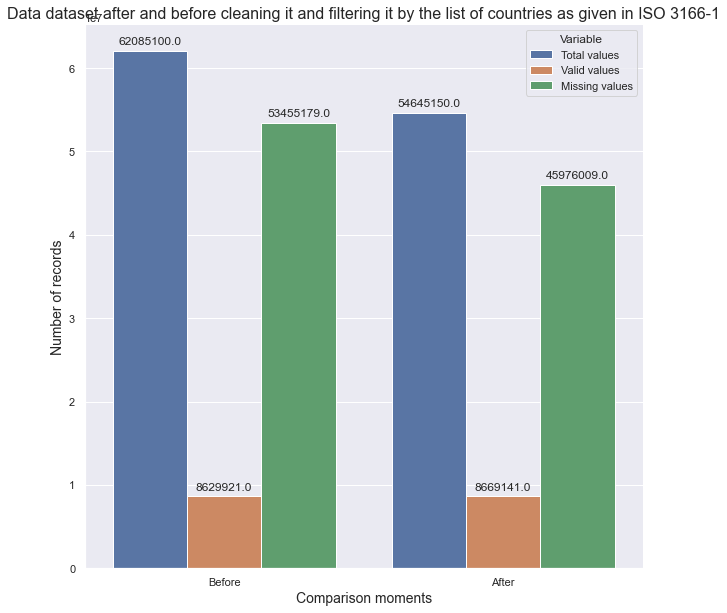

In [24]:
df_comparison = comparison_dfs(df_data, df_data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=14)
plt.ylabel("Number of records", size=14)
plt.title("Data dataset after and before cleaning it and filtering it by the list of countries as given in ISO 3166-1", size=16)
sns.despine(fig)

#### 3.4.

<a class="anchor" id="section_3_4"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.4. Making the selection of indicators</h3>
</div>

Based on the context of **Academy** international expansion project and the datasets, this is necessary to select specific indicators to work with them. 
To do that, I am going to select keywords to filter the indicators considering words related and not related to the indicators that we need to measure for the problem.

Below the steps to select the initial indicators

- Extract the list of indicators of the main dataset **`"df_data_copy"`**
- Define a list of keywords to extract the initial selection of indicators
    - List of word related to the indicators to measure. 
    - List of word NOT related to the indicators to measure.
- Apply the filter (list of words related and NOT related) in the list of indicators extracted of **`"df_data_copy"`** dataset.
- Analyze the indicators to select the initial list of indicator to analyze the countries. 
- Renaming the indicators selected to make them easier to read-
- Get the sample of data of **`"df_data_copy"`** dataset based on the initial list of indicators.

In [25]:
df_data_copy.head(5)

,Country Name,Country Code,2-alpha code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
91625,Afghanistan,AFG,AF,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,7.05911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91626,Afghanistan,AFG,AF,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,2.53138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91627,Afghanistan,AFG,AF,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,0.22154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91628,Afghanistan,AFG,AF,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,11.42652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91629,Afghanistan,AFG,AF,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_indicators = pd.DataFrame(df_data_copy[["Indicator Name", "Indicator Code"]])

In [27]:
df_indicators

,Indicator Name,Indicator Code
91625,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2
91626,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F
91627,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI
91628,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M
91629,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR
...,...,...
886925,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M
886926,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS
886927,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS
886928,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS


In [28]:
# Removing all duplicate values
df_indicators.drop_duplicates(subset="Indicator Code", keep="first", inplace=True)

In [29]:
df_indicators

,Indicator Name,Indicator Code
91625,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2
91626,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F
91627,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI
91628,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M
91629,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR
...,...,...
95285,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M
95286,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS
95287,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS
95288,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS


<div style="color: RGB(255,114,0);">
At this point, we have 3665 indicators
</div>

In [30]:
# List of keywords to extract the initial indicators based on keywords related to the indicators to measure
KEYWORDS_RELATED_INDICATORS = (
    "internet", "computer", "population", "education", "secondary", "university", "college", 
    "tertiaire", "bachelor", "financing", "funding", "income", "capita", "GDP"
)

In [31]:
# Extracting the initial indicators based on keywords related to the indicators to measure
df_indicators = pd.DataFrame(df_indicators[df_indicators["Indicator Name"].str.contains("|".join(KEYWORDS_RELATED_INDICATORS), case=False, na=False).any(level=0)])

In [32]:
# Amount of indicators in "df_indicators" on keywords related to the indicators to measure
df_indicators["Indicator Name"].nunique()

1958

<div style="color: RGB(255,114,0);">
At this point, we have more or less halved the number of indicators but, 
it is necessary to analyze the getting data to identify new keywords not interesting to the project context
</div>

In [33]:
df_indicators

,Indicator Name,Indicator Code
91625,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2
91626,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F
91627,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI
91628,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M
91633,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3
...,...,...
95285,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M
95286,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS
95287,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS
95288,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS


<div style="color: RGB(255,114,0);">
The following list is defined based on the analysis of the indicators obtained.<br> 
Some keywords are not interesting to the project context. <br>
So because of that I decided to rule out the indicators that contains the following criteria/words.<br>

- The target market is people of certain age, with education, among others. 
    - People over 50
    - People without education
    - People in primary, out-of-school
    - Teachers
- There a lot of rates that are not interesting to the project context. Below some of them.
    - years of schooling
    - Average years of
    - Repeaters
    - performance
    - School life expectancy
- In the case of "female" and "male", we can get the information group by "total" in the indicators.
- Finally, there are some words that contain other type of information not interesting for the project context. Below some of them. 
    - toilets
    - potable water
    - electricity
</div>

In [34]:
# List of keywords to extract the initial indicators based on keywords NOT related to the indicators to measure
KEYWORDS_NOT_RELATED_INDICATORS = (
    "50", "54", "55", "59", "60", "64", "65", "70", "75", "74", "80", "No Education", "Primary", "out-of-school", "years of schooling", "Average years of", 
    "Repeaters", "Repetition rate", "performance", "completion rate", "School life expectancy", "attendance rate", "Drop-out", "duration", "Labor force", 
    "teacher", "Government", "Policy", "expenditure", "illiterate population", "female", "male", "childhood", "toilets", "potable water", "electricity", 
    "single-sex toilets"    
)

In [35]:
# Ruling out the not interesting word of the sample from "df_data_copy"
df_indicators = pd.DataFrame(df_indicators[~df_indicators["Indicator Name"].str.contains("|".join(KEYWORDS_NOT_RELATED_INDICATORS), case=False, na=False).any(level=0)])

In [36]:
# Amount of indicators in "df_indicators" on keywords related to the indicators to measure
df_indicators["Indicator Name"].nunique()

296

<div style="color: RGB(255,114,0);">
At this point, we have narrowed the list down from 3665 indicators to 296 indicators.
</div>

In [37]:
df_indicators

,Indicator Name,Indicator Code
91625,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2
91627,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI
91633,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3
91635,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3.GPI
91645,"Adult literacy rate, population 15+ years, bot...",SE.ADT.LITR.ZS
...,...,...
95269,Wittgenstein Projection: Population in thousan...,PRJ.POP.ALL.2.MF
95275,Wittgenstein Projection: Population in thousan...,PRJ.POP.ALL.4.MF
95281,Wittgenstein Projection: Population in thousan...,PRJ.POP.ALL.3.MF
95286,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS


<div style="color: RGB(255,114,0);">
After analyzing the list of indicators, I decided to select as indicators the list caled <strong>INDICATORS</strong>.<br>

Inside this list, I decided to role out some indicators because similar indicator are already included. <br>
Below, the list of indicators  not included.<br>
- IT.CMP.PCMP.P2 - Personal computers (per 100 people)<br>
- NY.GNP.PCAP.PP.CD - GNI per capita, PPP (current international $)<br>
- SE.SEC.ENRL.GC - Enrolment in secondary general, both sexes (number)<br>
- SP.POP.GROW - Population growth (annual %)<br>
- UIS.E.4 - Enrolment in post-secondary non-tertiary education, both sexes (number)
</div>

In [38]:
INDICATORS = [
    "SP.POP.TOTL", "SP.POP.1524.TO.UN", "IT.NET.USER.P2", "UIS.E.3", "SE.TER.ENRL", "NY.GDP.PCAP.PP.CD"
]

In [39]:
df_indicators = pd.DataFrame(df_indicators.loc[df_indicators["Indicator Code"].isin(INDICATORS)])
pd.set_option("max_colwidth", None) # show full width of showing cols
df_indicators

,Indicator Name,Indicator Code
92829,"Enrolment in tertiary education, all programmes, both sexes (number)",SE.TER.ENRL
92839,"Enrolment in upper secondary education, both sexes (number)",UIS.E.3
92872,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD
93000,Internet users (per 100 people),IT.NET.USER.P2
94107,"Population, ages 15-24, total",SP.POP.1524.TO.UN
94158,"Population, total",SP.POP.TOTL


In [40]:
df_indicators.reset_index(drop=True, inplace=True) 

In [41]:
df_indicators

,Indicator Name,Indicator Code
0,"Enrolment in tertiary education, all programmes, both sexes (number)",SE.TER.ENRL
1,"Enrolment in upper secondary education, both sexes (number)",UIS.E.3
2,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD
3,Internet users (per 100 people),IT.NET.USER.P2
4,"Population, ages 15-24, total",SP.POP.1524.TO.UN
5,"Population, total",SP.POP.TOTL


<div style="color: RGB(255,114,0);">
Renaming the Indicators to make them easier to read
</div>

In [42]:
RENAMED_INDICATORS = [
    "Total population", "Ages 15-24 population", "Internet users", "Enrolment in upper secondary education", "Enrolment in tertiary education", "Gross domestic product per capita", 
]

In [43]:
df_indicator_rename_indicator = pd.DataFrame({
    "Indicator Code" : INDICATORS,
    "Renamed Indicator" : RENAMED_INDICATORS
})

In [44]:
df_indicators = df_indicators.merge(right=df_indicator_rename_indicator[["Indicator Code", "Renamed Indicator"]], on="Indicator Code", how="left")

<span style="color: #FF7200; font-weight: bold;">List of Indicators selected</span>
<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
 	</tr>
 	<tr>
  		<td align="center">IT.NET.USER.P2</td>
   		<td>Internet users (per 100 people)</td>
		<td>Internet users</td>
 	</tr>
	<tr>
  		<td align="center">SE.TER.ENRL</td>
   		<td>Enrolment in tertiary education, all programmes, both sexes (number)</td>
		<td>Enrolment in tertiary education</td>
 	</tr>
	<tr>
  		<td align="center">UIS.E.3</td>
   		<td>Enrolment in upper secondary education, both sexes (number)</td>
		<td>Enrolment in upper secondary education</td>
 	</tr>
	<tr>
  		<td align="center">NY.GDP.PCAP.PP.CD</td>
   		<td>GDP per capita, PPP (current international $)</td>
		<td>Gross domestic product per capita</td>
 	</tr>
	<tr>
  		<td align="center">SP.POP.1524.TO.UN</td>
   		<td>Population, ages 15-24, total</td>
		<td>Ages 15-24 population</td>
 	</tr>
    <tr>
  		<td align="center">SP.POP.TOTL</td>
   		<td>Population, total</td>
		<td>Total population</td>
 	</tr>
</table>

In [45]:
df_indicators

,Indicator Name,Indicator Code,Renamed Indicator
0,"Enrolment in tertiary education, all programmes, both sexes (number)",SE.TER.ENRL,Enrolment in tertiary education
1,"Enrolment in upper secondary education, both sexes (number)",UIS.E.3,Enrolment in upper secondary education
2,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Gross domestic product per capita
3,Internet users (per 100 people),IT.NET.USER.P2,Internet users
4,"Population, ages 15-24, total",SP.POP.1524.TO.UN,Ages 15-24 population
5,"Population, total",SP.POP.TOTL,Total population


In [46]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

In [47]:
# Getting the sample of data of "df_data_copy" based on the initial list of indicators
df_sample = pd.DataFrame(df_data_copy.loc[df_data_copy["Indicator Code"].isin(list(df_indicators["Indicator Code"]))])

In [48]:
df_sample = df_sample.merge(right=df_indicators[["Indicator Code", "Renamed Indicator"]], on="Indicator Code", how="left")

In [49]:
df_sample.columns

Index(['Country Name', 'Country Code', '2-alpha code', 'Indicator Name',
       'Indicator Code', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030',
       '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075',
       '2080', '2085', '2090', '2095', '2100', 'Renamed Indicator'],
      dtype='object')

In [50]:
ORDERING = [
    "Country Name", "Country Code", "2-alpha code", "Indicator Name", "Indicator Code", "Renamed Indicator", "1970", "1971", "1972", "1973", "1974", 
    "1975", "1976", "1977", "1978", "1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", 
    "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", 
    "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2020", "2025", "2030", "2035", "2040", 
    "2045", "2050", "2055", "2060", "2065", "2070", "2075", "2080", "2085", "2090", "2095", "2100", 
]

In [51]:
df_sample = df_sample[ORDERING]

In [52]:
df_sample

,Country Name,Country Code,2-alpha code,Indicator Name,Indicator Code,Renamed Indicator,1970,1971,1972,1973,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,Afghanistan,AFG,AF,"Enrolment in tertiary education, all programme...",SE.TER.ENRL,Enrolment in tertiary education,7732.0,9409.0,9817.0,11487.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,AF,"Enrolment in upper secondary education, both s...",UIS.E.3,Enrolment in upper secondary education,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,AF,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Gross domestic product per capita,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,AF,Internet users (per 100 people),IT.NET.USER.P2,Internet users,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,AF,"Population, ages 15-24, total",SP.POP.1524.TO.UN,Ages 15-24 population,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,Zimbabwe,ZWE,ZW,"Enrolment in upper secondary education, both s...",UIS.E.3,Enrolment in upper secondary education,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1274,Zimbabwe,ZWE,ZW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Gross domestic product per capita,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1275,Zimbabwe,ZWE,ZW,Internet users (per 100 people),IT.NET.USER.P2,Internet users,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1276,Zimbabwe,ZWE,ZW,"Population, ages 15-24, total",SP.POP.1524.TO.UN,Ages 15-24 population,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.5.

<a class="anchor" id="section_3_5"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.5. Selecting the countries based on Indicators</h3>
</div>

To select the countries, I will follow the steps below
- Clean the columns and rows NaN in **`df_sample`** datasets
- Select the minimum columns needed to work
- Preparing the dataset to work on it to select the countries
- Select the most recent data for each country by indicators
- Rule out the countries with population under 10 M 

In [53]:
# Analyzing the sample before working on it
df_initial_analysis(df_sample, ["Country Code", "Indicator Code"], "sample")


Initial Analysis of sample dataset
--------------------------------------------------------------------------
- Dataset shape:                  1278 rows and 71 columns
- Total of NaN values:            50920
- Percentage of NaN:              56.12 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         18
  + The empty column are:          ['2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100']

- The key(s): ['Country Code', 'Indicator Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 718.9+ KB )
--------------------------------------------------------------------------
                 Name     Type  Records
0        Country Name   object     1278
2        2-alpha code   object     1278
3      Indicator Name   object     1278
4      Indicator 

In [54]:
# Removing the NaN columns and rows to work with the df. 
df_sample_copy = df_sample.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [55]:
# Analyzing the sample before working on it
df_initial_analysis(df_sample_copy, ["Country Code", "Indicator Code"], "sample")


Initial Analysis of sample dataset
--------------------------------------------------------------------------
- Dataset shape:                  1278 rows and 53 columns
- Total of NaN values:            27916
- Percentage of NaN:              41.21 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): ['Country Code', 'Indicator Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 539.2+ KB )
--------------------------------------------------------------------------
                 Name     Type  Records
0        Country Name   object     1278
2        2-alpha code   object     1278
3      Indicator Name   object     1278
4      Indicator Code   object     1278
5   Renamed Indicator   object     1278
1        Country Code   object     1278
47               2011  float64     1081
40               2004  float64     107

<div style="color: RGB(255,114,0);">
Select the minimum columns needed to work.<br>
- Country Name<br>
- Indicator Code<br>
- Years (1972, 1973, ...)
</div>

In [56]:
df_sample_copy.columns

Index(['Country Name', 'Country Code', '2-alpha code', 'Indicator Name',
       'Indicator Code', 'Renamed Indicator', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016'],
      dtype='object')

In [57]:
YEAR_TO_WORK = [
    "1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979", "1980",
       "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989",
       "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998",
       "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007",
       "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"
]

In [58]:
COL_TO_WORK = ["Country Name", "Renamed Indicator"] + YEAR_TO_WORK

In [59]:
df_to_work = df_sample_copy[COL_TO_WORK].copy()

<div style="color: RGB(255,114,0);">
The nexts steps are towards the preparation of dataset.<br>
- Make a melt to pivot the dataframe from wide to long format.<br>
- Make a pivot table to transform the indicators in multiples columns, one column for each of them.<br>
- Select most recent value by <strong>Year</strong> for each <strong>Country</strong> considering the multiples <strong>Indicators</strong>.<br>
- Describe the dataset.
</div>

In [60]:
# Preaparing the data to work on it
df_to_work = df_to_work.melt(["Country Name", "Renamed Indicator"], var_name="Year", value_name="Value").sort_values(by=["Country Name", "Year", "Renamed Indicator"]).reset_index(drop=True)

In [61]:
df_to_work 

,Country Name,Renamed Indicator,Year,Value
0,Afghanistan,Ages 15-24 population,1972,NaN
1,Afghanistan,Enrolment in tertiary education,1972,9.817000e+03
2,Afghanistan,Enrolment in upper secondary education,1972,NaN
3,Afghanistan,Gross domestic product per capita,1972,NaN
4,Afghanistan,Internet users,1972,NaN
...,...,...,...,...
57505,Zimbabwe,Enrolment in tertiary education,2016,NaN
57506,Zimbabwe,Enrolment in upper secondary education,2016,NaN
57507,Zimbabwe,Gross domestic product per capita,2016,2.031020e+03
57508,Zimbabwe,Internet users,2016,2.311999e+01


<div style="color: RGB(255,114,0);">
Make a pivot table to transform the indicators in multiples columns, one column for each of them. 
</div>

In [62]:
df_to_work = df_to_work.pivot_table("Value", ["Country Name", "Year"], "Renamed Indicator")

In [63]:
df_to_work = pd.DataFrame(df_to_work).reset_index()

In [64]:
df_to_work

Renamed Indicator,Country Name,Year,Ages 15-24 population,Enrolment in tertiary education,Enrolment in upper secondary education,Gross domestic product per capita,Internet users,Total population
0,Afghanistan,1972,NaN,9817.0,NaN,NaN,NaN,11721940.0
1,Afghanistan,1973,NaN,11487.0,NaN,NaN,NaN,12027822.0
2,Afghanistan,1974,NaN,10956.0,NaN,NaN,NaN,12321541.0
3,Afghanistan,1975,NaN,12256.0,NaN,NaN,NaN,12590286.0
4,Afghanistan,1976,NaN,14214.0,NaN,NaN,NaN,12840299.0
...,...,...,...,...,...,...,...,...
9442,Zimbabwe,2012,3383141.0,94012.0,481006.0,1905.837880,12.000000,14710826.0
9443,Zimbabwe,2013,3371070.0,94115.0,490522.0,1997.052201,15.500000,15054506.0
9444,Zimbabwe,2014,3354236.0,NaN,NaN,2027.933139,16.364740,15411675.0
9445,Zimbabwe,2015,3333716.0,135575.0,NaN,2040.272449,22.742818,15777451.0


In [65]:
# Setting the name of the axis to delete the column "Indicator Code" of the dataset
df_to_work = df_to_work.rename_axis(None, axis=1)

In [66]:
df_to_work

,Country Name,Year,Ages 15-24 population,Enrolment in tertiary education,Enrolment in upper secondary education,Gross domestic product per capita,Internet users,Total population
0,Afghanistan,1972,NaN,9817.0,NaN,NaN,NaN,11721940.0
1,Afghanistan,1973,NaN,11487.0,NaN,NaN,NaN,12027822.0
2,Afghanistan,1974,NaN,10956.0,NaN,NaN,NaN,12321541.0
3,Afghanistan,1975,NaN,12256.0,NaN,NaN,NaN,12590286.0
4,Afghanistan,1976,NaN,14214.0,NaN,NaN,NaN,12840299.0
...,...,...,...,...,...,...,...,...
9442,Zimbabwe,2012,3383141.0,94012.0,481006.0,1905.837880,12.000000,14710826.0
9443,Zimbabwe,2013,3371070.0,94115.0,490522.0,1997.052201,15.500000,15054506.0
9444,Zimbabwe,2014,3354236.0,NaN,NaN,2027.933139,16.364740,15411675.0
9445,Zimbabwe,2015,3333716.0,135575.0,NaN,2040.272449,22.742818,15777451.0


<div style="color: RGB(255,114,0);">
Select most recent value by <strong>Year</strong> for each <strong>Country</strong> considering the multiples <strong>Indicators</strong>.<br>
</div>

In [67]:
df_countries_to_work = df_to_work.groupby("Country Name", as_index=False).last()

In [68]:
df_countries_to_work

,Country Name,Year,Ages 15-24 population,Enrolment in tertiary education,Enrolment in upper secondary education,Gross domestic product per capita,Internet users,Total population
0,Afghanistan,2016,7252785.0,262874.0,968769.0,1879.695509,10.595726,34656032.0
1,Albania,2016,556269.0,160527.0,151937.0,11865.501400,66.363445,2876101.0
2,Algeria,2016,6467818.0,1289474.0,1332584.0,15042.442301,42.945527,40606052.0
3,American Samoa,2016,NaN,1607.0,NaN,NaN,0.000000,55599.0
4,Andorra,2016,8715.0,501.0,1288.0,NaN,97.930637,77281.0
...,...,...,...,...,...,...,...,...
208,Virgin Islands (U.S.),2016,NaN,2488.0,NaN,NaN,59.608316,102951.0
209,West Bank and Gaza,2016,1053004.0,221018.0,142063.0,NaN,61.178385,4551566.0
210,"Yemen, Rep.",2016,5995687.0,267498.0,701984.0,2512.339519,24.579208,27584213.0
211,Zambia,2016,3068044.0,56680.0,NaN,3940.701882,25.506579,16591390.0


<div style="color: RGB(255,114,0);">
Deleting "Year" column.<br>
Analyzing the dataset.<br>
Describing the dataset.
</div>

In [69]:
del df_countries_to_work["Year"]

In [70]:
df_countries_to_work.columns

Index(['Country Name', 'Ages 15-24 population',
       'Enrolment in tertiary education',
       'Enrolment in upper secondary education',
       'Gross domestic product per capita', 'Internet users',
       'Total population'],
      dtype='object')

In [71]:
ORDERING = [
    "Country Name", "Total population", "Ages 15-24 population", "Internet users", 
    "Enrolment in upper secondary education", "Enrolment in tertiary education", 
    "Gross domestic product per capita"      
]

In [72]:
# Ordering the columns in  dataset
df_countries_to_work = df_countries_to_work[ORDERING]

In [73]:
df_countries_to_work

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
0,Afghanistan,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509
1,Albania,2876101.0,556269.0,66.363445,151937.0,160527.0,11865.501400
2,Algeria,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301
3,American Samoa,55599.0,NaN,0.000000,NaN,1607.0,NaN
4,Andorra,77281.0,8715.0,97.930637,1288.0,501.0,NaN
...,...,...,...,...,...,...,...
208,Virgin Islands (U.S.),102951.0,NaN,59.608316,NaN,2488.0,NaN
209,West Bank and Gaza,4551566.0,1053004.0,61.178385,142063.0,221018.0,NaN
210,"Yemen, Rep.",27584213.0,5995687.0,24.579208,701984.0,267498.0,2512.339519
211,Zambia,16591390.0,3068044.0,25.506579,NaN,56680.0,3940.701882


In [74]:
# Analyzing the sample after shaping it
df_initial_analysis(df_countries_to_work, ["Country Name"], "dataframe with indicators selected by country")


Initial Analysis of dataframe with indicators selected by country dataset
--------------------------------------------------------------------------
- Dataset shape:                  213 rows and 7 columns
- Total of NaN values:            78
- Percentage of NaN:              5.23 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): ['Country Name'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 13.3+ KB )
--------------------------------------------------------------------------
                                     Name     Type  Records
0                            Country Name   object      213
1                        Total population  float64      212
3                          Internet users  float64      207
5         Enrolment in tertiary education  float64      201
4  Enrolment in upper secondary education  f

In [75]:
df_countries_to_work.describe()

,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
count,2.120000e+02,1.910000e+02,207.000000,1.990000e+02,2.010000e+02,190.000000
mean,3.496557e+07,6.304360e+06,50.501729,1.240478e+06,1.055565e+06,20355.740919
std,1.359487e+08,2.344696e+07,29.090724,5.158803e+06,4.135762e+06,21871.398350
min,1.109700e+04,2.825000e+03,0.000000,3.530000e+02,1.940000e+02,700.063083
25%,8.735112e+05,2.926965e+05,25.036652,3.244400e+04,1.255400e+04,3963.223562
50%,6.535015e+06,1.168307e+06,53.226178,1.782540e+05,1.605270e+05,13010.876492
75%,2.380373e+07,4.604884e+06,76.143368,7.163120e+05,4.453240e+05,28309.919231
max,1.378665e+09,2.441202e+08,98.240016,5.522868e+07,4.336739e+07,127727.965544


<div style="color: RGB(255,114,0);">
<strong>Rule out</strong> the countries with <strong>populatiorn under 10 M</strong>
</div>

In [76]:
pd.set_option("max_colwidth", None) # show full width of showing cols
df_indicators

,Indicator Name,Indicator Code,Renamed Indicator
0,"Enrolment in tertiary education, all programmes, both sexes (number)",SE.TER.ENRL,Enrolment in tertiary education
1,"Enrolment in upper secondary education, both sexes (number)",UIS.E.3,Enrolment in upper secondary education
2,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,Gross domestic product per capita
3,Internet users (per 100 people),IT.NET.USER.P2,Internet users
4,"Population, ages 15-24, total",SP.POP.1524.TO.UN,Ages 15-24 population
5,"Population, total",SP.POP.TOTL,Total population


In [77]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div style="color: RGB(255,114,0);">
Countries to rule out due to their population is under 10 M based on "SP.POP.TOTL - Population, total" indicator (renamed to "Total population")	
</div>

In [78]:
df_countries_to_work[df_countries_to_work["Total population"]<10000000]

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
1,Albania,2876101.0,556269.0,66.363445,151937.0,160527.0,11865.501400
3,American Samoa,55599.0,NaN,0.000000,NaN,1607.0,NaN
4,Andorra,77281.0,8715.0,97.930637,1288.0,501.0,NaN
6,Antigua and Barbuda,100963.0,13588.0,73.000000,2615.0,1792.0,22705.482203
8,Armenia,2924816.0,446958.0,62.000000,103385.0,107665.0,8849.910837
...,...,...,...,...,...,...,...
200,United Arab Emirates,9269612.0,743608.0,90.600007,157821.0,156613.0,72540.205858
203,Uruguay,3444006.0,519298.0,66.400000,122666.0,145787.0,21661.578956
205,Vanuatu,270402.0,55081.0,24.000000,6167.0,955.0,3086.546182
208,Virgin Islands (U.S.),102951.0,NaN,59.608316,NaN,2488.0,NaN


<div style="color: RGB(255,114,0);">
    Countries to work due to their population is <strong>OVER 10 M</strong> based on "SP.POP.TOTL - Population, total" indicator (renamed to "Total population")
</div>

In [79]:
df_countries_to_work = pd.DataFrame(df_countries_to_work[df_countries_to_work["Total population"]>10000000])

In [80]:
df_countries_to_work

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
0,Afghanistan,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509
2,Algeria,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301
5,Angola,28813463.0,4259352.0,13.000000,303568.0,221037.0,6466.665045
7,Argentina,43847430.0,6886530.0,70.150764,1722700.0,2869450.0,19978.640971
10,Australia,24127159.0,2914620.0,88.238658,1104162.0,1453521.0,46789.927238
...,...,...,...,...,...,...,...
206,"Venezuela, RB",31568179.0,5479911.0,60.000000,892370.0,2123041.0,17639.136767
207,Vietnam,92701100.0,16939813.0,46.500000,NaN,2466643.0,6434.917943
210,"Yemen, Rep.",27584213.0,5995687.0,24.579208,701984.0,267498.0,2512.339519
211,Zambia,16591390.0,3068044.0,25.506579,NaN,56680.0,3940.701882


<div style="color: RGB(255,114,0);">
   Keeping only rows at least 4 indicators non-NaN values
</div>

In [81]:
df_countries_to_work = df_countries_to_work.dropna(subset=RENAMED_INDICATORS, thresh=4)
df_countries_to_work

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
0,Afghanistan,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509
2,Algeria,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301
5,Angola,28813463.0,4259352.0,13.000000,303568.0,221037.0,6466.665045
7,Argentina,43847430.0,6886530.0,70.150764,1722700.0,2869450.0,19978.640971
10,Australia,24127159.0,2914620.0,88.238658,1104162.0,1453521.0,46789.927238
...,...,...,...,...,...,...,...
206,"Venezuela, RB",31568179.0,5479911.0,60.000000,892370.0,2123041.0,17639.136767
207,Vietnam,92701100.0,16939813.0,46.500000,NaN,2466643.0,6434.917943
210,"Yemen, Rep.",27584213.0,5995687.0,24.579208,701984.0,267498.0,2512.339519
211,Zambia,16591390.0,3068044.0,25.506579,NaN,56680.0,3940.701882


## Chapter 4.

<a class="anchor" id="chapter4"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Analyzing the selected countries</h2>
</div>

#### 4.1.

<a class="anchor" id="section_4_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">4.1. Country comparison by indicator</h3>
</div>

<span style="color: #FF7200; font-weight: bold;">Comparison of countries by</span>
<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
 	</tr>
 	<tr>
  		<td align="center">IT.NET.USER.P2</td>
   		<td>Internet users (per 100 people)</td>
		<td>Internet users</td>
 	</tr>
</table>

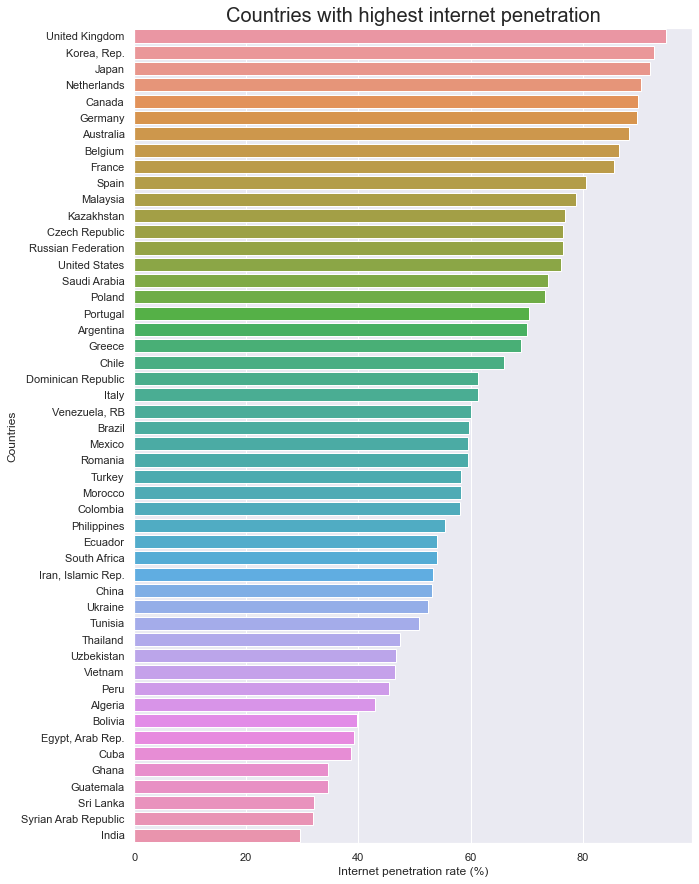

In [82]:
plt.figure(figsize=(10, 15))
plot = sns.barplot(x="Internet users",
                   y="Country Name",                    
                   data=df_countries_to_work[["Country Name", "Internet users"]].sort_values("Internet users", ascending=False).head(50)
)
plt.title("Countries with highest internet penetration", size=20)
plot.set(xlabel="Internet penetration rate (%)", ylabel="Countries")
plt.rcParams["axes.labelsize"] = 12
plt.show()

<span style="color: #FF7200; font-weight: bold;">Comparison of countries by</span>
<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
 	</tr>
	<tr>
  		<td align="center">SP.POP.1524.TO.UN</td>
   		<td>Population, ages 15-24, total</td>
		<td>Ages 15-24 population</td>
 	</tr>
</table>

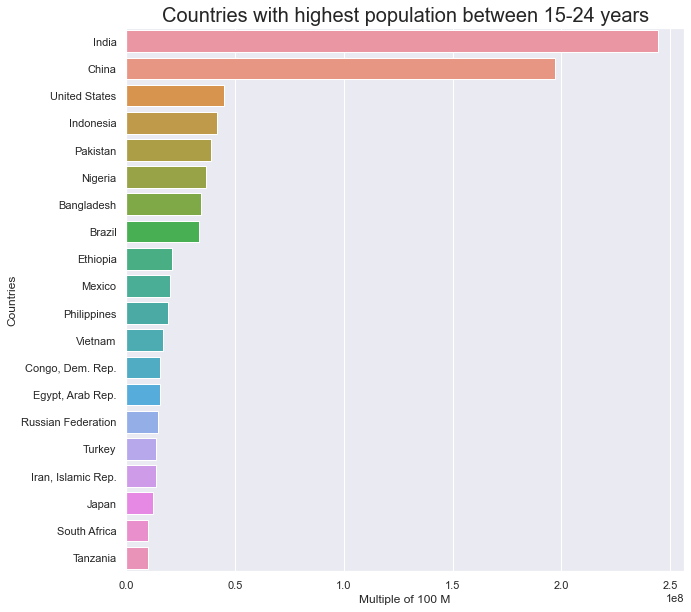

In [83]:
plt.figure(figsize=(10, 10))
plot = sns.barplot(x="Ages 15-24 population",
                   y="Country Name",                    
                   data=df_countries_to_work[["Country Name", "Ages 15-24 population"]].sort_values("Ages 15-24 population", ascending=False).head(20)
)
plt.title("Countries with highest population between 15-24 years", size=20)
plot.set(xlabel="Multiple of 100 M", ylabel="Countries")
plt.rcParams["axes.labelsize"] = 12
plt.show()

<span style="color: #FF7200; font-weight: bold;">Comparison of countries by</span>
<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
 	</tr>
	<tr>
  		<td align="center">NY.GDP.PCAP.PP.CD</td>
   		<td>GDP per capita, PPP (current international $)</td>
		<td>Gross domestic product per capita</td>
 	</tr>
</table>

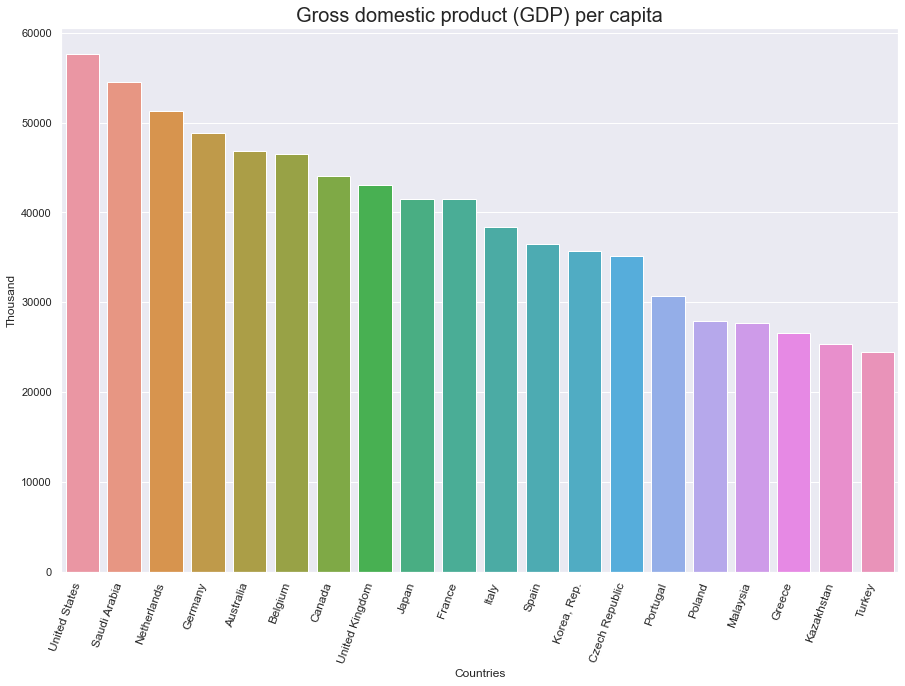

In [84]:
df_temp = df_countries_to_work[["Country Name", "Gross domestic product per capita"]].sort_values("Gross domestic product per capita", ascending=False).head(20)

plt.figure(figsize=(15, 10))
plot = sns.barplot(x="Country Name", 
                   y="Gross domestic product per capita", 
                   data=df_temp
)
plt.title("Gross domestic product (GDP) per capita", size=20)
plot.set_xticklabels(labels=df_temp["Country Name"], rotation=70, size=12, horizontalalignment="right")
plot.set(xlabel="Countries", ylabel="Thousand")
plt.show()

<span style="color: #FF7200; font-weight: bold;">Comparison of countries by:</span>
<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
 	</tr>
	<tr>
  		<td align="center">SE.TER.ENRL</td>
   		<td>Enrolment in tertiary education, all programmes, both sexes (number)</td>
		<td>Enrolment in tertiary education</td>
 	</tr>
	<tr>
  		<td align="center">UIS.E.3</td>
   		<td>Enrolment in upper secondary education, both sexes (number)</td>
		<td>Enrolment in upper secondary education</td>
 	</tr>
</table>

In [85]:
df_temp = df_countries_to_work[["Country Name", "Enrolment in tertiary education", "Enrolment in upper secondary education"]].copy(deep=True)
df_temp["Enrolment total"] = df_countries_to_work["Enrolment in upper secondary education"] + df_countries_to_work["Enrolment in tertiary education"]

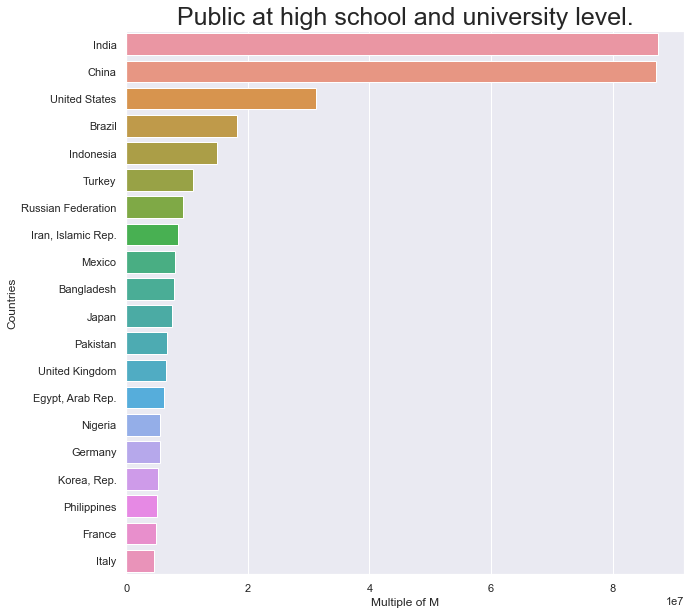

In [86]:
plt.figure(figsize=(10, 10))
plot = sns.barplot(x="Enrolment total", 
                   y="Country Name",
                   data=df_temp.sort_values("Enrolment total", ascending=False).head(20)
)
plt.title("Public at high school and university level.", size=25)
plot.set(xlabel="Multiple of M", ylabel="Countries")
plt.show()

#### 4.2.

<a class="anchor" id="section_4_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">4.2. Potential customers by country</h3>
</div>

To determine the number of potential customers by country, it is necessary to add the customers and then multiply it by the percentage of internet penetration

In [87]:
df_potential_customer = df_countries_to_work[["Country Name", "Internet users", "Enrolment in tertiary education", "Enrolment in upper secondary education"]].copy(deep=True)

In [88]:
df_potential_customer["Potential customers"] = (df_countries_to_work["Enrolment in upper secondary education"] + df_countries_to_work["Enrolment in tertiary education"]) * df_countries_to_work["Internet users"]/100

In [89]:
df_potential_customer = df_potential_customer.sort_values("Potential customers", ascending=False).head(20)

<div style="color: RGB(255,114,0);">
Defining a <strong>CategoricalDtype</strong> to create a custom sort based on the first 20 countries of potential clients
</div>

In [90]:
categorical_countries_order_by_potential_customer = CategoricalDtype(
    df_potential_customer["Country Name"],
    ordered=True
)

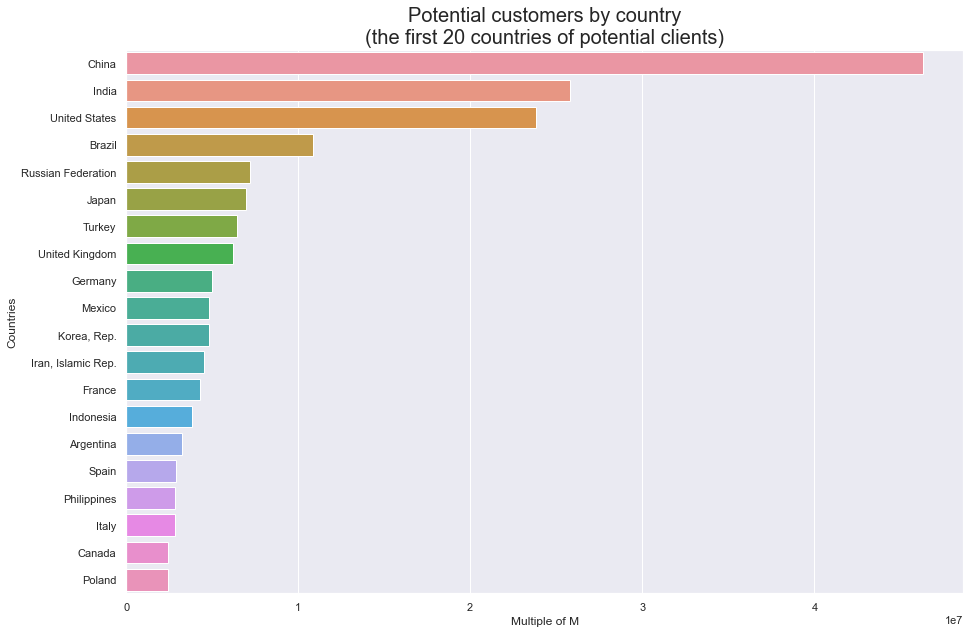

In [91]:
plt.figure(figsize=(15, 10))
plot = sns.barplot(x="Potential customers", 
                   y="Country Name",
                   data=df_potential_customer
)
plt.title("Potential customers by country\n(the first 20 countries of potential clients)", size=20)
plot.set(xlabel="Multiple of M", ylabel="Countries")
plt.savefig("img/potentialCustomer.png")
plt.show()

#### 4.3.

<a class="anchor" id="section_4_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">4.3. Evolution of internet in the first 20 countries of potential clients</h3>
</div>

At this point, the idea is to know the evolution of internet penetration rate in the first 20 countries of potential clients.
To do that I am going to work the file as follows.
- Filtering by the first 20 countries of potencial clients identified before
- Filtering by indicator **`IT.NET.USER.P2`** - Internet users (per 100 people) - renamed to **`Internet users`**
- Keeping only the 10 columns more recent with data available

In [92]:
df_evolution_internet = df_sample_copy[["Country Name", "Renamed Indicator"] + YEAR_TO_WORK].copy()

In [93]:
# Filter "Countries" based on the list of the first 20 countries of potential clients
df_evolution_internet = df_evolution_internet[df_evolution_internet["Country Name"].isin(df_potential_customer["Country Name"])]

In [94]:
# Filter by indicator penetration of internet per 100 people
df_evolution_internet = df_evolution_internet[df_evolution_internet["Renamed Indicator"] == "Internet users"]

In [95]:
del df_evolution_internet["Renamed Indicator"]

In [96]:
df_evolution_internet = df_evolution_internet.dropna(axis="columns", how="all")

In [97]:
df_evolution_internet_copy = df_evolution_internet.copy()

<div style="color: RGB(255,114,0);">
Ordering the list based on the first 20 countries of potential clients <strong>CategoricalDtype</strong>
</div>

In [98]:
df_evolution_internet_copy["Country Name"] = df_evolution_internet_copy["Country Name"].astype(categorical_countries_order_by_potential_customer)

In [99]:
df_evolution_internet_copy.sort_values("Country Name")

,Country Name,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
237,China,0.000000,NaN,NaN,0.000169,0.001168,0.004955,0.013082,0.032395,0.168540,...,16.000000,22.600000,28.90,34.30,38.300000,42.300117,45.800000,47.900000,50.300000,53.200000
519,India,0.000000,NaN,0.000111,0.000218,0.001070,0.026229,0.046334,0.070768,0.139027,...,3.950000,4.380000,5.12,7.50,10.070000,12.580061,15.100000,21.000000,26.000000,29.547163
1215,United States,0.784729,1.163194,1.724203,2.271673,4.862781,9.237088,16.419353,21.616401,30.093197,...,75.000000,74.000000,71.00,71.69,69.729461,74.700000,71.400000,73.000000,74.554202,76.176737
159,Brazil,0.000000,0.003288,0.012946,0.025498,0.037673,0.105138,0.450789,0.786079,1.477875,...,30.880000,33.830000,39.22,40.65,45.690000,48.560000,51.040000,54.551002,58.327952,59.682747
939,Russian Federation,0.000000,NaN,0.000673,0.013447,0.053817,0.148151,0.269753,0.472964,0.812744,...,24.660000,26.830000,29.00,43.00,49.000000,63.800000,67.970000,70.520000,73.410000,76.409085
573,Japan,0.020294,0.040438,0.096678,0.401278,0.799684,1.594363,4.372982,9.163077,13.414041,...,74.300000,75.400000,78.00,78.21,79.054114,79.496400,88.219429,89.106833,91.058028,92.000000
1167,Turkey,0.000000,NaN,NaN,0.008458,0.049869,0.081691,0.192725,0.473695,0.698805,...,28.630000,34.370000,36.40,39.82,43.065710,45.130000,46.250000,51.040000,53.744979,58.347734
1209,United Kingdom,0.087355,0.174231,0.260615,0.519762,1.036609,1.895168,4.123650,7.385399,13.669983,...,75.090000,78.390000,83.56,85.00,85.379999,87.479998,89.844100,91.610000,92.000300,94.775801
423,Germany,0.125892,0.250274,0.435285,0.463635,0.922541,1.837738,3.054805,6.711087,9.877852,...,75.160000,78.000000,79.00,82.00,81.270000,82.349998,84.170000,86.190000,87.589800,89.647101
747,Mexico,0.000000,0.005881,0.017308,0.028305,0.043339,0.102564,0.200406,0.627312,1.265783,...,20.810000,21.710000,26.34,31.05,37.176295,39.750000,43.460000,44.390000,57.431043,59.540446


<div style="color: RGB(255,114,0);">
Evolution of internet penetration rate for the last 10 years with available data
</div>

In [100]:
df_evolution_internet_copy.drop(df_evolution_internet_copy.iloc[:,1:18], inplace=True, axis=1)

In [101]:
df_evolution_internet_copy.head(3)

,Country Name,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
45,Argentina,25.946633,28.112623,34.00,45.00,51.00,55.80,59.90,64.700000,68.043064,70.150764
159,Brazil,30.880000,33.830000,39.22,40.65,45.69,48.56,51.04,54.551002,58.327952,59.682747
207,Canada,73.200000,76.700000,80.30,80.30,83.00,83.00,85.80,87.120000,88.470000,89.840000


In [102]:
df_evolution_internet_copy = df_evolution_internet_copy.melt(id_vars=["Country Name"], var_name="year", value_name="Internet users")

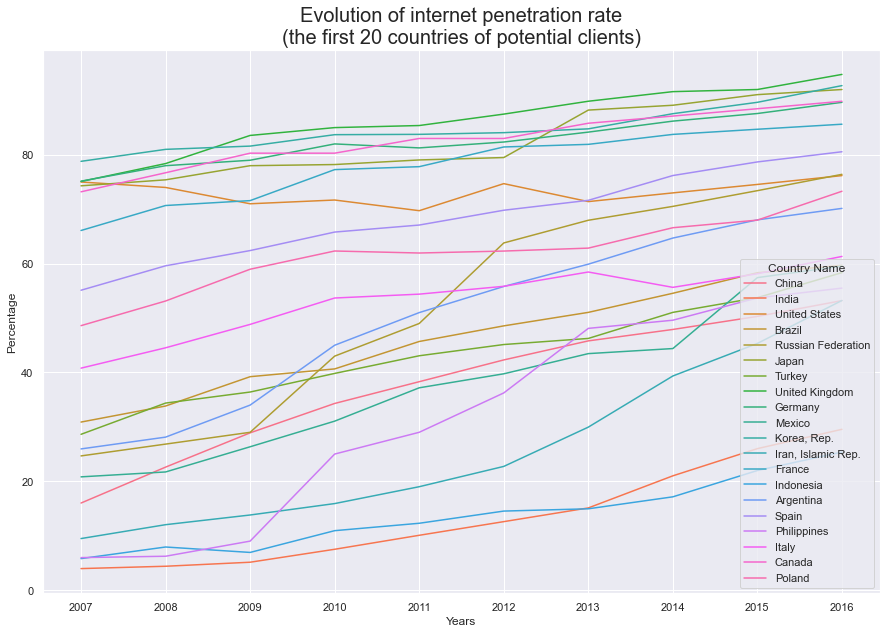

In [103]:
plt.figure(figsize=(15, 10))
plot = sns.lineplot(x="year",
                    y="Internet users",
                    hue="Country Name",
                    data=df_evolution_internet_copy
)
plt.title("Evolution of internet penetration rate\n(the first 20 countries of potential clients)", size=20)
plot.set(xlabel="Years", ylabel="Percentage")
plt.savefig("img/evolutionInternetPenetration.png")
plt.show()

#### 4.4.

<a class="anchor" id="section_4_4"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">4.4. Evolution of potential customers in the first 20 countries of potential clients</h3>
</div>

At this point, the idea is to know the evolution of potential customer in the first 20 countries of potential clients.
To do that I am going to work the file as follows.
- Filtering by the first 20 countries of potencial clients identified before
- Keeping only the 10 columns more recent with data available

In [104]:
df_evolution_potential_customer = df_sample_copy[["Country Name", "Renamed Indicator"] + YEAR_TO_WORK].copy(deep=True)

In [105]:
# Filter "Countries" based on the list of the first 20 countries of potential clients
df_evolution_potential_customer = df_evolution_potential_customer[df_evolution_potential_customer["Country Name"].isin(df_potential_customer["Country Name"])]

In [106]:
df_evolution_potential_customer = df_evolution_potential_customer[df_evolution_potential_customer["Renamed Indicator"].isin(["Internet users", "Enrolment in tertiary education", "Enrolment in upper secondary education"])]

In [107]:
df_evolution_potential_customer = df_evolution_potential_customer.dropna(axis="columns", how="all")

In [108]:
df_evolution_potential_customer.head(4)

,Country Name,Renamed Indicator,1972,1973,1974,1975,1976,1977,1978,1979,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
42,Argentina,Enrolment in tertiary education,351287.0,423824.0,497727.0,596736.0,601395.0,536450.0,477725.0,498928.0,...,2.208291e+06,2.287874e+06,2387049.0,2520985.0,2660514.0,2726557.0,2768211.0,2869450.0,NaN,NaN
43,Argentina,Enrolment in upper secondary education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.451352e+06,1.464197e+06,1492714.0,1520478.0,1651653.0,1685178.0,1722700.0,NaN,NaN,NaN
45,Argentina,Internet users,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.594663e+01,2.811262e+01,34.0,45.0,51.0,55.8,59.9,64.7,6.804306e+01,70.150764
156,Brazil,Enrolment in tertiary education,696215.0,785159.0,954674.0,1089808.0,1119849.0,1182411.0,1251116.0,1340662.0,...,5.272877e+06,5.958135e+06,6115138.0,6552707.0,6929324.0,7241405.0,7541112.0,8072146.0,8.285475e+06,NaN


<div style="color: RGB(255,114,0);">
Evolution of potential customer for the last 10 years
</div>

In [109]:
df_evolution_potential_customer.drop(df_evolution_potential_customer.iloc[:,2:36], inplace=True, axis=1)

In [110]:
df_evolution_potential_customer.head(5)

,Country Name,Renamed Indicator,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
42,Argentina,Enrolment in tertiary education,2.202032e+06,2.208291e+06,2.287874e+06,2387049.0,2520985.0,2660514.0,2726557.0,2768211.0,2869450.0,NaN,NaN
43,Argentina,Enrolment in upper secondary education,1.447612e+06,1.451352e+06,1.464197e+06,1492714.0,1520478.0,1651653.0,1685178.0,1722700.0,NaN,NaN,NaN
45,Argentina,Internet users,2.092720e+01,2.594663e+01,2.811262e+01,34.0,45.0,51.0,55.8,59.9,64.7,6.804306e+01,70.150764
156,Brazil,Enrolment in tertiary education,NaN,5.272877e+06,5.958135e+06,6115138.0,6552707.0,6929324.0,7241405.0,7541112.0,8072146.0,8.285475e+06,NaN
157,Brazil,Enrolment in upper secondary education,NaN,9.073330e+06,9.169279e+06,9200656.0,9284000.0,9395813.0,9442334.0,9949583.0,NaN,NaN,NaN


In [111]:
# Calculate evolution of potential customers based on functions "aggregate_evolution_of_potential_customers"
df_evolution_potential_customer = df_evolution_potential_customer.set_index("Renamed Indicator").groupby("Country Name").aggregate(aggregate_evolution_of_potential_customers).reset_index()

In [112]:
df_evolution_potential_customer.head(5)

,Country Name,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Argentina,7.637684e+05,9.495541e+05,1.054806e+06,1.319119e+06,1.818658e+06,2.199205e+06,2.461748e+06,2.690056e+06,NaN,NaN,NaN
1,Brazil,NaN,4.430109e+06,5.117604e+06,6.006854e+06,6.437621e+06,7.458955e+06,8.101624e+06,8.927251e+06,NaN,NaN,NaN
2,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,China,6.559457e+06,1.080350e+07,1.597285e+07,2.130825e+07,2.597879e+07,2.905145e+07,3.249076e+07,3.666497e+07,4.101841e+07,NaN,NaN
4,France,2.296934e+06,3.216234e+06,3.414841e+06,3.437052e+06,3.763039e+06,3.799187e+06,4.001106e+06,4.030164e+06,4.176811e+06,NaN,NaN


In [113]:
df_evolution_potential_customer = df_evolution_potential_customer.melt(id_vars=["Country Name"], var_name="Year", value_name="Value")

In [114]:
df_evolution_potential_customer.head(5)

,Country Name,Year,Value
0,Argentina,2006,7.637684e+05
1,Brazil,2006,NaN
2,Canada,2006,NaN
3,China,2006,6.559457e+06
4,France,2006,2.296934e+06


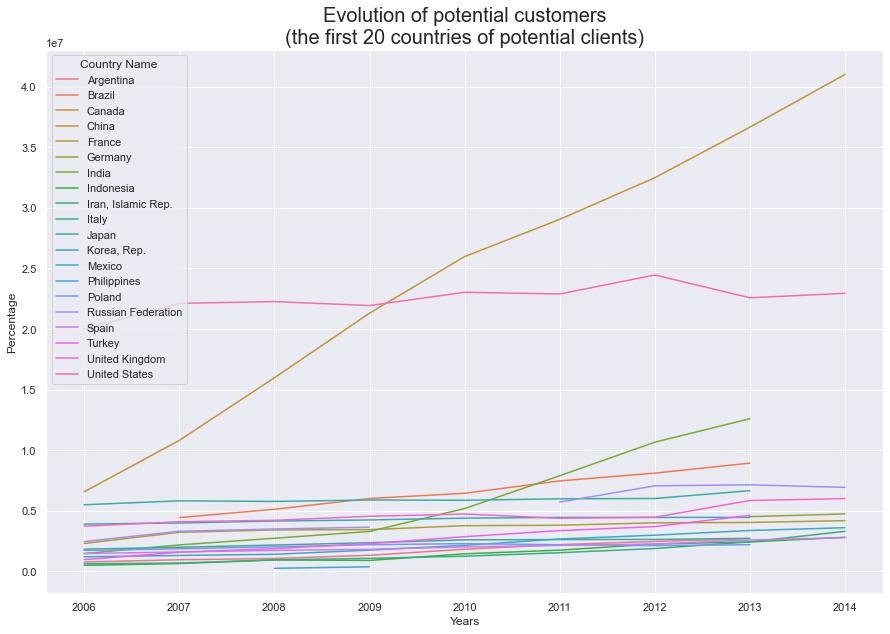

In [115]:
plt.figure(figsize=(15, 10))
plot = sns.lineplot(x="Year",
                    y="Value",
                    hue="Country Name",
                    data=df_evolution_potential_customer
)
plt.title("Evolution of potential customers\n(the first 20 countries of potential clients)", size=20)
plot.set(xlabel="Years", ylabel="Percentage")
plt.show()

#### 4.5.

<a class="anchor" id="section_4_5"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">4.5. Internet penetration compared to population ages 15-24</h3>
</div>

In [116]:
df_temp = df_countries_to_work[df_countries_to_work["Country Name"].isin(df_potential_customer.sort_values("Potential customers", ascending=False).head(10)["Country Name"])]

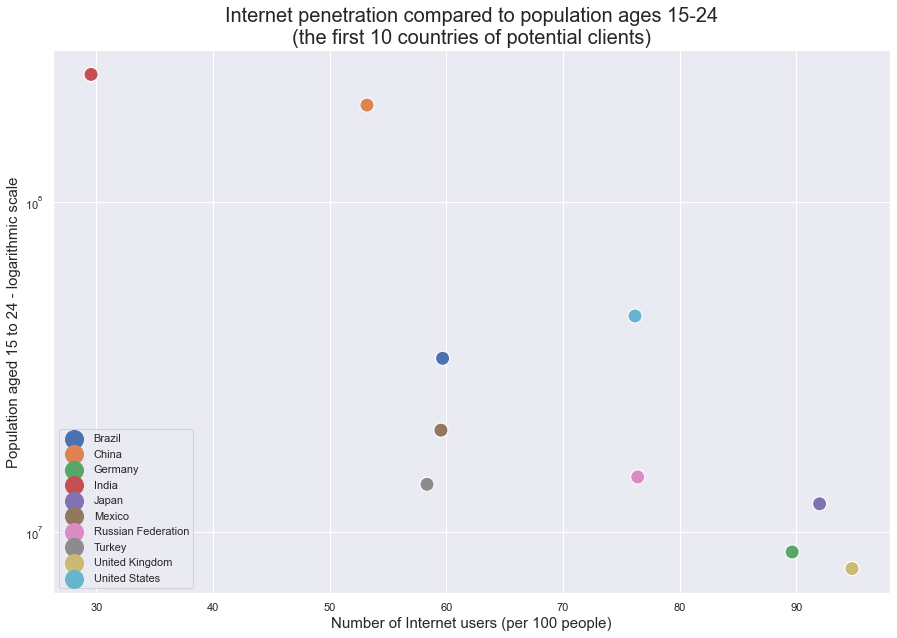

In [117]:
plt.figure(figsize = (15,10))
ax = plt.gca()
plot = sns.scatterplot(x=df_temp["Internet users"], y=df_temp["Ages 15-24 population"], hue=df_temp["Country Name"], s=200)

ax.set_yscale('log')
plt.title("Internet penetration compared to population ages 15-24\n(the first 10 countries of potential clients)", size=20)
plt.xlabel("Number of Internet users (per 100 people)", size=15)
plt.ylabel("Population aged 15 to 24 - logarithmic scale", size=15)
plt.legend(loc="lower left", markerscale=3)
plt.show()

#### 4.6.

<a class="anchor" id="section_4_6"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">4.6. Normalization of the selected indicator for each country</h3>
</div>

In this point, I normalize the selected indicator for each country.
To do that, I consider the follows steps
- Filter the select indicator data by the 10 first countries with potential customer
- Normalize the dataframe considering **`The min-max`** approach (range of [0,1])

<div style="color: RGB(255,114,0);">
Filter the select indicator data by the 10 first countries with potential customer
</div>

In [118]:
df_temp = df_countries_to_work[df_countries_to_work["Country Name"].isin(df_potential_customer.sort_values("Potential customers", ascending=False).head(10)["Country Name"])]

In [119]:
df_temp

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
26,Brazil,2.076529e+08,33595574.0,59.682747,9949583.00,8285475.00,15153.210558
39,China,1.378665e+09,197026759.0,53.200000,43709224.00,43367392.00,15559.231347
70,Germany,8.266768e+07,8682394.0,89.647101,2579952.25,2977781.00,48884.762872
86,India,1.324171e+09,244120201.0,29.547163,55228676.00,32107420.00,6583.372050
95,Japan,1.269945e+08,12157426.0,92.000000,3682920.00,3862460.00,41476.360298
124,Mexico,1.275404e+08,20336734.0,59.540446,4682336.00,3419391.00,17877.357845
156,Russian Federation,1.443424e+08,14661984.0,76.409085,2823004.00,6592416.00,23162.632165
194,Turkey,7.951243e+07,13930222.0,58.347734,4995623.00,6062886.00,24412.462558
201,United Kingdom,6.563724e+07,7731522.0,94.775801,4195081.50,2352932.75,43080.956403
202,United States,3.231275e+08,45147517.0,76.176737,11736315.00,19531728.00,57638.159088


<div style="color: RGB(255,114,0);">
Calling the function to normalize the dataframe
</div>

In [120]:
df_countries_to_work_normalized = df_normalization(df_temp, "Country Name")

In [121]:
df_countries_to_work_normalized

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
26,Brazil,0.108159,0.109413,0.461999,0.139977,0.144645,0.167856
39,China,1.000000,0.800780,0.362614,0.781202,1.000000,0.175808
70,Germany,0.012970,0.004022,0.921373,0.000000,0.015235,0.828549
86,India,0.958498,1.000000,0.000000,1.000000,0.725463,0.000000
95,Japan,0.046730,0.018723,0.957445,0.020950,0.036805,0.683442
124,Mexico,0.047145,0.053324,0.459818,0.039932,0.026002,0.221213
156,Russian Federation,0.059942,0.029318,0.718426,0.004616,0.103366,0.324735
194,Turkey,0.010567,0.026222,0.441533,0.045883,0.090455,0.349215
201,United Kingdom,0.000000,0.000000,1.000000,0.030677,0.000000,0.714871
202,United States,0.196104,0.158282,0.714864,0.173914,0.418847,1.000000


In [122]:
df_countries_to_work_normalized = pd.melt(df_countries_to_work_normalized, id_vars="Country Name", var_name="Indicators", value_name="Value")

In [123]:
df_countries_to_work_normalized.head(5)

,Country Name,Indicators,Value
0,Brazil,Total population,0.108159
1,China,Total population,1.000000
2,Germany,Total population,0.012970
3,India,Total population,0.958498
4,Japan,Total population,0.046730


<span style="color: #FF7200; font-weight: bold;">List of Indicators selected</span>
<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
 	</tr>
 	<tr>
  		<td align="center">IT.NET.USER.P2</td>
   		<td>Internet users (per 100 people)</td>
		<td>Internet users</td>
 	</tr>
	<tr>
  		<td align="center">SE.TER.ENRL</td>
   		<td>Enrolment in tertiary education, all programmes, both sexes (number)</td>
		<td>Enrolment in tertiary education</td>
 	</tr>
	<tr>
  		<td align="center">UIS.E.3</td>
   		<td>Enrolment in upper secondary education, both sexes (number)</td>
		<td>Enrolment in upper secondary education</td>
 	</tr>
	<tr>
  		<td align="center">NY.GDP.PCAP.PP.CD</td>
   		<td>GDP per capita, PPP (current international $)</td>
		<td>Gross domestic product per capita</td>
 	</tr>
	<tr>
  		<td align="center">SP.POP.1524.TO.UN</td>
   		<td>Population, ages 15-24, total</td>
		<td>Ages 15-24 population</td>
 	</tr>
    <tr>
  		<td align="center">SP.POP.TOTL</td>
   		<td>Population, total</td>
		<td>Total population</td>
 	</tr>
</table>

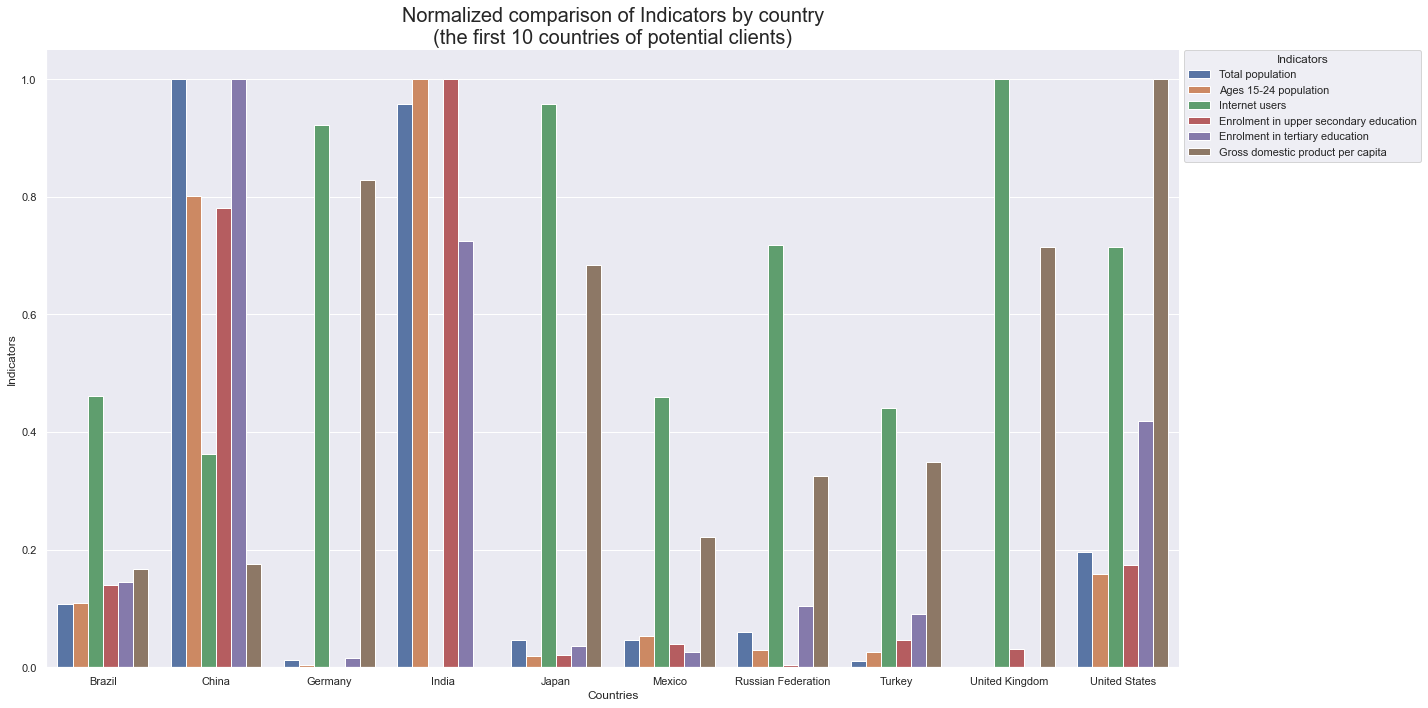

In [124]:
fig, ax1 = plt.subplots(figsize=(20, 10))
plot = sns.barplot(x="Country Name", y="Value", hue="Indicators", data=df_countries_to_work_normalized, ax=ax1)
plt.title("Normalized comparison of Indicators by country\n(the first 10 countries of potential clients)", size=20)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Indicators")
plt.tight_layout()
plt.xlabel("Countries", size=12)
plt.ylabel("Indicators", size=12)
sns.despine(fig)

#### 4.7.

<a class="anchor" id="section_4_7"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">4.7. Normalization of the selected indicator by region</h3>
</div>

Now, as a summary, I show the selected indicators normalized and grouped by Region.
To do that, I consider the follows steps
- Identifier the potential customer in each country adding the all students for internet penetration
- Calculing the mean by Region for all indicators
- Normalize the dataframe considering **`The min-max`** approach (range of [0,1])

<div style="color: RGB(255,114,0);">
Identifying the potential customer in each country adding the all students for internet penetration
</div>

In [125]:
df_potential_customer = df_countries_to_work[["Country Name", "Internet users", "Enrolment in tertiary education", "Enrolment in upper secondary education"]].copy(deep=True)

In [126]:
df_potential_customer["Potential customers"] = (df_countries_to_work["Enrolment in upper secondary education"] + df_countries_to_work["Enrolment in tertiary education"]) * df_countries_to_work["Internet users"]/100

In [127]:
df_potential_customer = df_potential_customer.sort_values("Potential customers", ascending=False)

In [128]:
df_temp = df_countries_to_work[df_countries_to_work["Country Name"].isin(df_potential_customer.sort_values("Potential customers", ascending=False)["Country Name"])]

In [129]:
df_temp.shape

(86, 7)

<div style="color: RGB(255,114,0);">
Inserting the <strong>Region</strong> column in the Dataset to group by it
</div>

In [130]:
df_temp = df_temp.merge(right=df_country[["Short Name", "Region"]], left_on="Country Name", right_on="Short Name", how="left")

In [131]:
df_temp

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita,Short Name,Region
0,Afghanistan,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509,Afghanistan,South Asia
1,Algeria,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301,Algeria,Middle East & North Africa
2,Angola,28813463.0,4259352.0,13.000000,303568.0,221037.0,6466.665045,Angola,Sub-Saharan Africa
3,Argentina,43847430.0,6886530.0,70.150764,1722700.0,2869450.0,19978.640971,Argentina,Latin America & Caribbean
4,Australia,24127159.0,2914620.0,88.238658,1104162.0,1453521.0,46789.927238,Australia,East Asia & Pacific
...,...,...,...,...,...,...,...,...,...
81,"Venezuela, RB",31568179.0,5479911.0,60.000000,892370.0,2123041.0,17639.136767,NaN,NaN
82,Vietnam,92701100.0,16939813.0,46.500000,NaN,2466643.0,6434.917943,Vietnam,East Asia & Pacific
83,"Yemen, Rep.",27584213.0,5995687.0,24.579208,701984.0,267498.0,2512.339519,NaN,NaN
84,Zambia,16591390.0,3068044.0,25.506579,NaN,56680.0,3940.701882,Zambia,Sub-Saharan Africa


In [132]:
df_temp.columns

Index(['Country Name', 'Total population', 'Ages 15-24 population',
       'Internet users', 'Enrolment in upper secondary education',
       'Enrolment in tertiary education', 'Gross domestic product per capita',
       'Short Name', 'Region'],
      dtype='object')

In [133]:
del df_temp["Short Name"]

In [134]:
df_temp = df_temp[["Country Name", "Region", "Total population", "Ages 15-24 population", "Internet users", "Enrolment in upper secondary education", "Enrolment in tertiary education", "Gross domestic product per capita"]]

In [135]:
df_temp = pd.DataFrame(df_temp).copy()

In [136]:
df_temp.head(5)

,Country Name,Region,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
0,Afghanistan,South Asia,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509
1,Algeria,Middle East & North Africa,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301
2,Angola,Sub-Saharan Africa,28813463.0,4259352.0,13.000000,303568.0,221037.0,6466.665045
3,Argentina,Latin America & Caribbean,43847430.0,6886530.0,70.150764,1722700.0,2869450.0,19978.640971
4,Australia,East Asia & Pacific,24127159.0,2914620.0,88.238658,1104162.0,1453521.0,46789.927238


In [137]:
del df_temp["Country Name"]

In [138]:
df_temp

,Region,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
0,South Asia,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509
1,Middle East & North Africa,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301
2,Sub-Saharan Africa,28813463.0,4259352.0,13.000000,303568.0,221037.0,6466.665045
3,Latin America & Caribbean,43847430.0,6886530.0,70.150764,1722700.0,2869450.0,19978.640971
4,East Asia & Pacific,24127159.0,2914620.0,88.238658,1104162.0,1453521.0,46789.927238
...,...,...,...,...,...,...,...
81,NaN,31568179.0,5479911.0,60.000000,892370.0,2123041.0,17639.136767
82,East Asia & Pacific,92701100.0,16939813.0,46.500000,NaN,2466643.0,6434.917943
83,NaN,27584213.0,5995687.0,24.579208,701984.0,267498.0,2512.339519
84,Sub-Saharan Africa,16591390.0,3068044.0,25.506579,NaN,56680.0,3940.701882


<div style="color: RGB(255,114,0);">
Calculating the mean considering the region
</div>

In [139]:
df_temp.groupby(['Region']).mean()

,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
Region,,,,,,
East Asia & Pacific,2.155622e+08,3.169081e+07,53.774223,7.184215e+06,6.372612e+06,18387.042305
Europe & Central Asia,3.837880e+07,4.641276e+06,73.254769,1.675981e+06,1.581276e+06,32157.520780
Latin America & Caribbean,4.618377e+07,7.669361e+06,49.964885,2.053602e+06,1.774450e+06,13426.238336
Middle East & North Africa,2.919913e+07,5.232297e+06,46.491162,9.452848e+05,8.691762e+05,21280.648071
North America,1.797070e+08,2.476051e+07,83.008368,6.633854e+06,1.037194e+07,50831.671257
South Asia,2.941947e+08,5.577585e+07,20.940692,1.156821e+07,6.177258e+06,5352.495545
Sub-Saharan Africa,3.446501e+07,6.632611e+06,17.838482,6.390251e+05,2.698914e+05,3079.587786


In [140]:
df_temp.reset_index(drop=True)

,Region,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
0,South Asia,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509
1,Middle East & North Africa,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301
2,Sub-Saharan Africa,28813463.0,4259352.0,13.000000,303568.0,221037.0,6466.665045
3,Latin America & Caribbean,43847430.0,6886530.0,70.150764,1722700.0,2869450.0,19978.640971
4,East Asia & Pacific,24127159.0,2914620.0,88.238658,1104162.0,1453521.0,46789.927238
...,...,...,...,...,...,...,...
81,NaN,31568179.0,5479911.0,60.000000,892370.0,2123041.0,17639.136767
82,East Asia & Pacific,92701100.0,16939813.0,46.500000,NaN,2466643.0,6434.917943
83,NaN,27584213.0,5995687.0,24.579208,701984.0,267498.0,2512.339519
84,Sub-Saharan Africa,16591390.0,3068044.0,25.506579,NaN,56680.0,3940.701882


<div style="color: RGB(255,114,0);">
Calling the function to normalize the dataframe
</div>

In [141]:
df_regions_normalized = df_normalization(df_temp, "Region")

In [142]:
df_regions_normalized

,Region,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita
0,South Asia,0.017782,0.025464,0.111798,0.016704,0.005917,0.019354
1,Middle East & North Africa,0.022130,0.022234,0.453128,0.023297,0.029593,0.250852
2,Sub-Saharan Africa,0.013512,0.013148,0.137166,0.004649,0.004953,0.100027
3,Latin America & Caribbean,0.024499,0.023957,0.740176,0.030367,0.066031,0.337667
4,East Asia & Pacific,0.010087,0.007615,0.931025,0.019158,0.033376,0.809208
...,...,...,...,...,...,...,...
81,NaN,0.015525,0.018170,0.633073,0.015319,0.048817,0.296521
82,East Asia & Pacific,0.060202,0.065319,0.490632,NaN,0.056741,0.099468
83,NaN,0.012614,0.020292,0.259341,0.011869,0.006024,0.030480
84,Sub-Saharan Africa,0.004580,0.008247,0.269125,NaN,0.001162,0.055601


In [143]:
df_regions_normalized = pd.melt(df_regions_normalized, id_vars="Region", var_name="Indicators", value_name="Value")

In [144]:
df_regions_normalized.head(5)

,Region,Indicators,Value
0,South Asia,Total population,0.017782
1,Middle East & North Africa,Total population,0.022130
2,Sub-Saharan Africa,Total population,0.013512
3,Latin America & Caribbean,Total population,0.024499
4,East Asia & Pacific,Total population,0.010087


<span style="color: #FF7200; font-weight: bold;">List of Indicators selected</span>
<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
 	</tr>
 	<tr>
  		<td align="center">IT.NET.USER.P2</td>
   		<td>Internet users (per 100 people)</td>
		<td>Internet users</td>
 	</tr>
	<tr>
  		<td align="center">SE.TER.ENRL</td>
   		<td>Enrolment in tertiary education, all programmes, both sexes (number)</td>
		<td>Enrolment in tertiary education</td>
 	</tr>
	<tr>
  		<td align="center">UIS.E.3</td>
   		<td>Enrolment in upper secondary education, both sexes (number)</td>
		<td>Enrolment in upper secondary education</td>
 	</tr>
	<tr>
  		<td align="center">NY.GDP.PCAP.PP.CD</td>
   		<td>GDP per capita, PPP (current international $)</td>
		<td>Gross domestic product per capita</td>
 	</tr>
	<tr>
  		<td align="center">SP.POP.1524.TO.UN</td>
   		<td>Population, ages 15-24, total</td>
		<td>Ages 15-24 population</td>
 	</tr>
    <tr>
  		<td align="center">SP.POP.TOTL</td>
   		<td>Population, total</td>
		<td>Total population</td>
 	</tr>
</table>

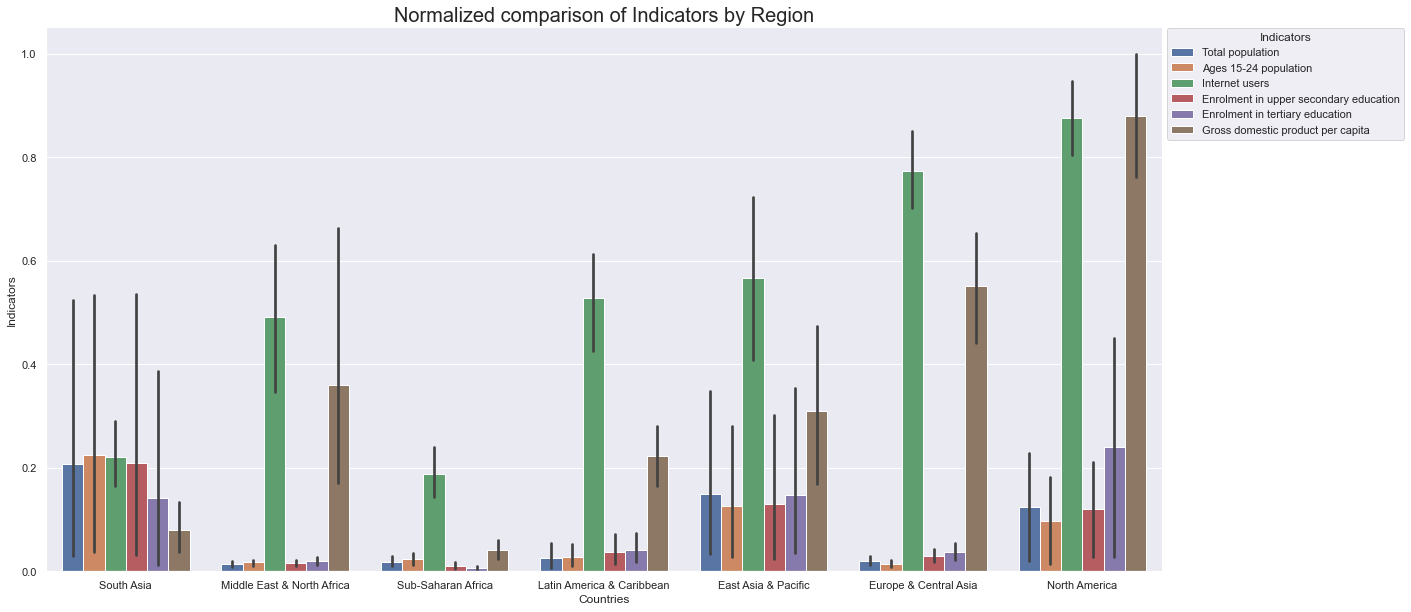

In [145]:
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.title("Normalized comparison of Indicators by Region", size=20)
plot = sns.barplot(x="Region", y="Value", hue="Indicators", data=df_regions_normalized, ax=ax1)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Indicators")
plt.xlabel("Countries", size=12)
plt.ylabel("Indicators", size=12)
sns.despine(fig)

## Chapter 5.

<a class="anchor" id="chapter2"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Countries by score</h2>
</div>

#### 5.1.

<a class="anchor" id="section_5_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">5.1. Selecting countries by score</h3>
</div>

Finally, I am going to select countries by defined score based on the selected indicators. 
To do that, I consider the follows steps
- Filter the selected indicators considering only the most important indicators for the analysis
- Add the **`SE.TER.ENRL`** and **`UIS.E.3`** indicators to work with them as a single indicator
- Delete countries with not enough data
- Define the **`weighing`** for each indicator selected
- Normalize the dataframe considering **`The min-max`** approach (range of [0,1])
- Make the **`weighted sum`**

<span style="font-weight: bold;">List of Indicators selected for scoring. Most important indicators for the analysis</span>
<table style="border: 1px solid #FFFFFF; color: #FFFFFF;" align="left">
	<tr style="border: 1px solid #FFFFFF; color: #FFFFFF;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
        <th style="font-weight: bold;">Considered for score</th>
 	</tr>
 	<tr>
  		<td align="center">IT.NET.USER.P2</td>
   		<td>Internet users (per 100 people)</td>
		<td>Internet users</td>
        <td align="center" style="font-weight: bold;">YES</td>
 	</tr>
	<tr>
  		<td align="center">SE.TER.ENRL</td>
   		<td>Enrolment in tertiary education, all programmes, both sexes (number)</td>
		<td>Enrolment in tertiary education</td>
        <td align="center" style="font-weight: bold;">YES</td>
 	</tr>
	<tr>
  		<td align="center">UIS.E.3</td>
   		<td>Enrolment in upper secondary education, both sexes (number)</td>
		<td>Enrolment in upper secondary education</td>
        <td align="center" style="font-weight: bold;">YES</td>
 	</tr>
	<tr>
  		<td align="center">NY.GDP.PCAP.PP.CD</td>
   		<td>GDP per capita, PPP (current international $)</td>
		<td>Gross domestic product per capita</td>
        <td align="center" style="font-weight: bold;">YES</td>
 	</tr>
	<tr>
  		<td align="center">SP.POP.1524.TO.UN</td>
   		<td>Population, ages 15-24, total</td>
		<td>Ages 15-24 population</td>
        <td align="center">NO</td>
 	</tr>
    <tr>
  		<td align="center">SP.POP.TOTL</td>
   		<td>Population, total</td>
		<td>Total population</td>
        <td align="center">NO</td>
 	</tr>
</table>

In [146]:
# Copying the dataframe to work on it
df_score = df_countries_to_work.copy()

<span style="color: RGB(255,114,0); font-weight: bold;">Adding the columns **`Enrolment in upper secondary education`** and **`Enrolment in tertiary education`** in a new column called</span> **`Enrolment in education`**</span>


In [147]:
df_score["Enrolment in education"] = df_score.fillna(0)["Enrolment in upper secondary education"] + df_score.fillna(0)["Enrolment in tertiary education"]

In [148]:
df_score

,Country Name,Total population,Ages 15-24 population,Internet users,Enrolment in upper secondary education,Enrolment in tertiary education,Gross domestic product per capita,Enrolment in education
0,Afghanistan,34656032.0,7252785.0,10.595726,968769.0,262874.0,1879.695509,1231643.0
2,Algeria,40606052.0,6467818.0,42.945527,1332584.0,1289474.0,15042.442301,2622058.0
5,Angola,28813463.0,4259352.0,13.000000,303568.0,221037.0,6466.665045,524605.0
7,Argentina,43847430.0,6886530.0,70.150764,1722700.0,2869450.0,19978.640971,4592150.0
10,Australia,24127159.0,2914620.0,88.238658,1104162.0,1453521.0,46789.927238,2557683.0
...,...,...,...,...,...,...,...,...
206,"Venezuela, RB",31568179.0,5479911.0,60.000000,892370.0,2123041.0,17639.136767,3015411.0
207,Vietnam,92701100.0,16939813.0,46.500000,NaN,2466643.0,6434.917943,2466643.0
210,"Yemen, Rep.",27584213.0,5995687.0,24.579208,701984.0,267498.0,2512.339519,969482.0
211,Zambia,16591390.0,3068044.0,25.506579,NaN,56680.0,3940.701882,56680.0


<div style="color: RGB(255,114,0);">
Keeping columns interesting for the score
</div>

In [149]:
COLUMNS_TO_KEEP_FOR_THE_SCORE = [
    "Enrolment in education", "Internet users", "Gross domestic product per capita"
]

In [150]:
df_score = df_score[["Country Name"] + COLUMNS_TO_KEEP_FOR_THE_SCORE].copy(deep=True)

In [151]:
df_score

,Country Name,Enrolment in education,Internet users,Gross domestic product per capita
0,Afghanistan,1231643.0,10.595726,1879.695509
2,Algeria,2622058.0,42.945527,15042.442301
5,Angola,524605.0,13.000000,6466.665045
7,Argentina,4592150.0,70.150764,19978.640971
10,Australia,2557683.0,88.238658,46789.927238
...,...,...,...,...
206,"Venezuela, RB",3015411.0,60.000000,17639.136767
207,Vietnam,2466643.0,46.500000,6434.917943
210,"Yemen, Rep.",969482.0,24.579208,2512.339519
211,Zambia,56680.0,25.506579,3940.701882


<div style="color: RGB(255,114,0);">
Analyzing the dataframe
</div>

In [152]:
df_initial_analysis(df_score, "Country Name", "df Score")


Initial Analysis of df Score dataset
--------------------------------------------------------------------------
- Dataset shape:                  86 rows and 4 columns
- Total of NaN values:            4
- Percentage of NaN:              1.16 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0

- The key(s): Country Name is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 3.4+ KB )
--------------------------------------------------------------------------
                                Name     Type  Records
0                       Country Name   object       86
1             Enrolment in education  float64       86
2                     Internet users  float64       86
3  Gross domestic product per capita  float64       82


<div style="color: RGB(255,114,0);">
Countries with not enough data
</div>

In [153]:
df_temp = df_score[df_score.isna().any(axis=1)]

In [154]:
df_temp

,Country Name,Enrolment in education,Internet users,Gross domestic product per capita
47,Cuba,678004.0,38.765867,NaN
100,"Korea, Dem. People’s Rep.",1810436.0,0.000000,NaN
171,Somalia,62687.0,1.880000,NaN
185,Syrian Arab Republic,1184172.0,31.869627,NaN


<div style="color: RGB(255,114,0);">
Deleting the countries with not enough data
</div>

In [155]:
df_score = df_score[~df_score["Country Name"].isin(df_temp["Country Name"])]

In [156]:
df_score

,Country Name,Enrolment in education,Internet users,Gross domestic product per capita
0,Afghanistan,1231643.0,10.595726,1879.695509
2,Algeria,2622058.0,42.945527,15042.442301
5,Angola,524605.0,13.000000,6466.665045
7,Argentina,4592150.0,70.150764,19978.640971
10,Australia,2557683.0,88.238658,46789.927238
...,...,...,...,...
206,"Venezuela, RB",3015411.0,60.000000,17639.136767
207,Vietnam,2466643.0,46.500000,6434.917943
210,"Yemen, Rep.",969482.0,24.579208,2512.339519
211,Zambia,56680.0,25.506579,3940.701882


<span style="color: #FF7200;">Define the **`weighing`** for each indicator selected</span><br><br>
<span style="color: #FF7200;">To define this, I made some assumptions as follows</span>
<ol style="color: #FF7200;">
  <li>The most important indicator is <span style="background: #424242; color: #FFFFFF; font-weight: bold;">&nbsp;Enrolment in education&nbsp;</span> because it is the <strong>target market</strong></li>
  <li>The most important indicator is <span style="background: #424242; color: #FFFFFF; font-weight: bold;">&nbsp;Internet users&nbsp;</span> because <strong>Academy</strong> offers <strong>on-line</strong> formation</li>
  <li>The formation price is <strong>not expensive</strong></li>
</ol>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Indicator Code</th>
		<th style="font-weight: bold;">Indicator Name</th>
		<th style="font-weight: bold;">Renamed Indicator</th>
        <th style="font-weight: bold;">Weighing</th>
 	</tr>
 	<tr>
		<td align="center">Enrolment in education</td>
        <td align="center">50 %</td>
  		<td align="center">SE.TER.ENRL<br>UIS.E.3</td>
   		<td>Enrolment in tertiary education, all programmes, both sexes (number)<br>Enrolment in upper secondary education</td>
 	</tr>      
 	<tr>
		<td align="center">Internet users</td>
        <td align="center">35 %</td>
  		<td align="center">IT.NET.USER.P2</td>
   		<td>Internet users (per 100 people)</td>
 	</tr>
	<tr>
		<td align="center">Gross domestic product per capita</td>
        <td align="center">15 %</td>
  		<td align="center">NY.GDP.PCAP.PP.CD</td>
   		<td>GDP per capita, PPP (current international $)</td>
 	</tr>
</table>

In [157]:
weight = pd.DataFrame(pd.Series([0.50, 0.35, 0.15], index=list(COLUMNS_TO_KEEP_FOR_THE_SCORE), name=0))

In [158]:
weight

,0
Enrolment in education,0.50
Internet users,0.35
Gross domestic product per capita,0.15


<div style="color: RGB(255,114,0);">
Calling the function to normalize the dataframe
</div>

In [159]:
df_score = df_normalization(df_score, "Country Name")

<div style="color: RGB(255,114,0);">
Calculating the score
</div>

In [160]:
df_score["Score"] = df_score.iloc[:,1:].dot(weight)

In [161]:
df_score.sort_values("Score", ascending=False).head(10)

,Country Name,Enrolment in education,Internet users,Gross domestic product per capita,Score
39,China,0.997029,0.540360,0.259941,0.726632
86,India,1.000000,0.278867,0.102079,0.612915
202,United States,0.357973,0.794379,1.000000,0.607019
201,United Kingdom,0.074908,1.000000,0.743977,0.499051
95,Japan,0.086329,0.969312,0.715756,0.489787
70,Germany,0.063569,0.943300,0.846051,0.488847
135,Netherlands,0.018124,0.951745,0.888872,0.475503
101,"Korea, Rep.",0.059151,0.977234,0.615058,0.463866
10,Australia,0.029216,0.927729,0.809208,0.460694
34,Canada,0.031344,0.945432,0.760583,0.460661


In [162]:
df_score = pd.melt(df_score.sort_values("Score", ascending=False).head(5), id_vars="Country Name", var_name="Indicators", value_name="Value")

In [163]:
df_score.head(5)

,Country Name,Indicators,Value
0,China,Enrolment in education,0.997029
1,India,Enrolment in education,1.000000
2,United States,Enrolment in education,0.357973
3,United Kingdom,Enrolment in education,0.074908
4,Japan,Enrolment in education,0.086329


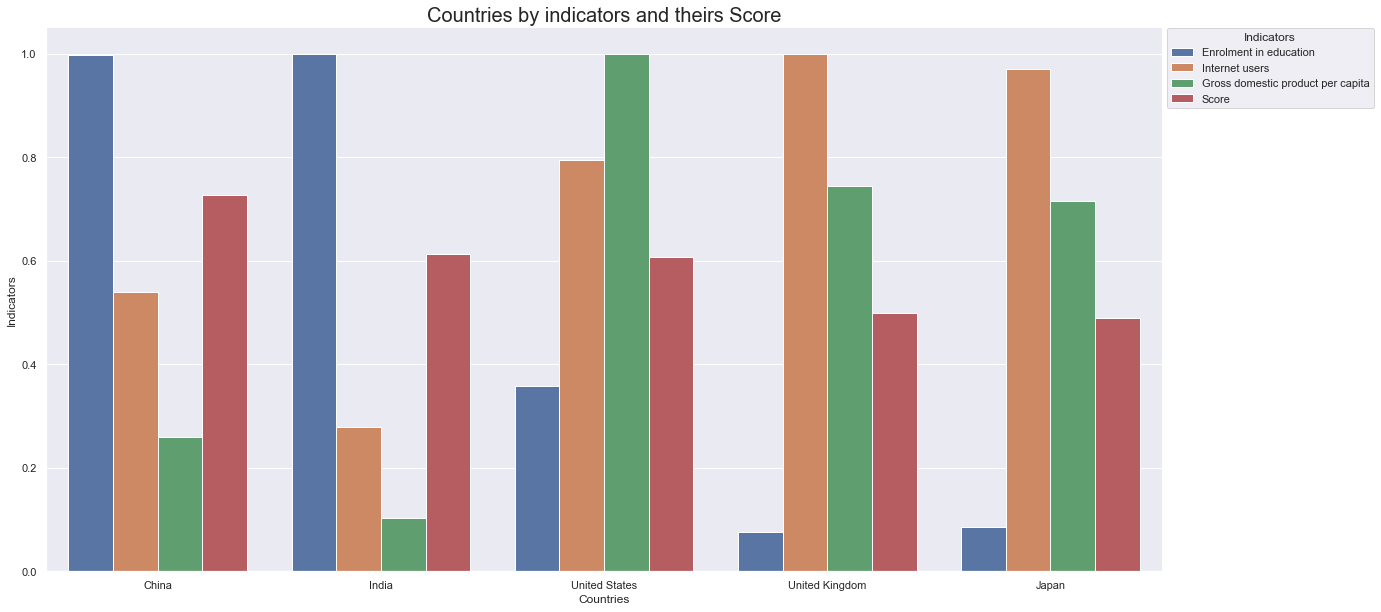

In [164]:
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.title("Countries by indicators and theirs Score", size=20)
plot = sns.barplot(x="Country Name", y="Value", hue="Indicators", data=df_score, ax=ax1)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Indicators")
plt.xlabel("Countries", size=12)
plt.ylabel("Indicators", size=12)
sns.despine(fig)